In [ ]:
# version requirements
!pip install --quiet prince==0.7.1
!pip install --quiet pytorch_lightning==1.9.3
!pip install --quiet lightning_lite==1.8.6
!pip uninstall --quiet torch torchvision torchaudio -y
!pip install --quiet torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip uninstall --quiet matplotlib -y
!pip install --quiet matplotlib==3.6.3
!pip uninstall --quiet scikit-learn -y
!pip install --quiet scikit-learn==1.2.2
!pip uninstall --quiet pandas -y
!pip install --quiet pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 99.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requir

Make sure to restart your runtime to apply version changes

In [ ]:
'''                               
               __   _____________  ___  
               \ \ / /  _  \ ___ \/ _ \ 
                \ V /| | | | |_/ / /_\ \
                /   \| | | | ___ \  _  |
               / /^\ \ |/ /| |_/ / | | |
               \/   \/___/ \____/\_| |_/
                                                                       
        eXplainable Deep Behavior Analysis (v1.0)
                @author: Eldad Tal-Shir
'''

# Dependencies
from typing import Optional
import pandas as pd
import numpy as np
import math
import pickle
import csv
from scipy.special import softmax
from matplotlib import pyplot as plt
import prince
import os
import shutil
import torch
from torch import nn, optim
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision import transforms, datasets
from torchvision.models import resnet101 as net
from pytorch_lightning import Trainer, LightningDataModule, LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from lightning_lite.utilities.seed import seed_everything, reset_seed
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import silhouette_score, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.neighbors import NearestCentroid
from PIL import Image

class preprocessing():
  def __init__(self,dataframe:pd.DataFrame,featureframe:pd.DataFrame,sequential:bool=False):
    super().__init__()
    self.dataframe = dataframe
    self.featureframe = featureframe
    self.sequential = sequential

  def clean_data(self,target_column:str,drop_outliers_mode:Optional[str]='micro',outlier_features:Optional[list]=None,ensure_stratification_n_splits:int=None,dropna:bool=True,export_to_csv:Optional[bool]=False): # Drop agents that exhibited outlier patterns according to outlier_features and prepare for sampling
    assert self.dataframe is not None, 'dataframe should be defined for data cleaning' # Verify that dataframe is defined
    drop_dictionary={}
    if type(self.dataframe.index)!=pd.RangeIndex: # If a non-default index is currently used
      old_index_name=self.dataframe.index.name # Retain it
      self.dataframe.reset_index(drop=False,inplace=True) # Set a default one for resetting between drops
    else:
      old_index_name=None
    if dropna is True:
      print("Data cleaning: dropping N/A")
      columns = outlier_features
      columns.append(target_column)
      self.dataframe.dropna(axis=0,subset=columns,inplace=True) # Drop rows with null values on target/label column and columns that are used to find outliers
      self.dataframe.reset_index(drop=True,inplace=True)
    if self.dataframe[target_column].dtype!=np.int64 or set(range(len(self.dataframe[target_column])))!=set(self.dataframe[target_column]): # If target column is not configured for classification
      print("Encoding values for classification")
      encoder = LabelEncoder()
      encoder.fit(self.dataframe[target_column].sort_values()) # Encode labels
      self.dataframe[f'{target_column}_unencoded'] = self.dataframe[target_column] # Move unencoded labels to new column
      self.dataframe[target_column] = encoder.transform(self.dataframe[target_column]) # Overwrite with encoded labels
      print(f"Mapping: {dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))}")
    if drop_outliers_mode is not None: # If outliers should be dropped
      outlier_features = [i for i in outlier_features if self.dataframe[i].dtype in [np.float64, np.int64]] # Ensure outlier columns are int/float
      if len(outlier_features)==0:
        raise TypeError('Outlier columns selected are not int/float')
      if drop_outliers_mode.lower()=='macro': # Drop outliers across all data points (i.e., treat data as one class)
        print("Using macro mode to drop outlier values")
        for feature in outlier_features:
          sorted_feature = np.sort(self.dataframe[feature]) # Sort feature column
          q1=np.percentile(sorted_feature,25,method='midpoint') # Get Q1 of ordered feature
          q3=np.percentile(sorted_feature,75,method='midpoint') # Get Q3 of ordered feature
          low_lim=float(q1)-float(q3-q1)*1.5 # Get lower thershold for outlier detection
          upp_lim=float(q3)+float(q3-q1)*1.5 # Get upper thershold for outlier detection
          drop_dictionary[feature]=[low_lim,upp_lim] # Append to dict to prevent biased IQRs from dropping between iterations
        for feature in drop_dictionary:
          for ind,value in enumerate(self.dataframe[feature]):
            if value<drop_dictionary[feature][0] or value>drop_dictionary[feature][1]: # If outlier
              self.dataframe.drop(ind,axis=0,inplace=True) # Drop
              self.dataframe.reset_index(drop=True,inplace=True) # Reset index for next iteration
      elif drop_outliers_mode.lower()=='micro': # Drop outliers within each class
        assert target_column is not None,'target column should be defined for outlier removal'
        print("Using micro mode to drop outlier values")
        frames = [] # Prepare container for per-class dataframes
        for target in set(self.dataframe[target_column]): # For each target class
          tempframe = self.dataframe.loc[self.dataframe[target_column]==target].copy() # Extract a sub-df containing its values
          for feature in outlier_features:
            sorted_feature = np.sort(tempframe[feature]) # Sort feature column
            q1=np.percentile(sorted_feature,25,method='midpoint') # Get Q1 of ordered feature
            q3=np.percentile(sorted_feature,75,method='midpoint') # Get Q3 of ordered feature
            low_lim=float(q1)-float(q3-q1)*1.5 # Get lower thershold for outlier detection
            upp_lim=float(q3)+float(q3-q1)*1.5 # Get upper thershold for outlier detection
            drop_dictionary[feature]=[low_lim,upp_lim] # Append to dict to prevent biased IQRs from dropping between iterations
          for feature in drop_dictionary:
            tempframe.reset_index(drop=True,inplace=True) # Reset index for next feature
            for ind,value in enumerate(tempframe[feature]):
              tempframe.reset_index(drop=True,inplace=True) # Reset index for next iteration
              if value<drop_dictionary[feature][0] or value>drop_dictionary[feature][1]: # If outlier
                tempframe.drop(ind,axis=0,inplace=True) # Drop
          frames.append(tempframe) # Append outlier-dropped frame to container
        self.dataframe = pd.concat(frames,ignore_index=True) # Merge per-class dfs into main df
      else:
        raise ValueError("Data cleaning supports only 'micro' and 'macro' modes")
    if type(ensure_stratification_n_splits) is int: # Drop classes where n<n_splits
      assert target_column is not None,'target column should be defined for stratification'
      print(f"Ensuring each class can be stratified into {ensure_stratification_n_splits} strata")
      self.dataframe = self.dataframe.groupby(target_column).filter(lambda x:len(x)>=ensure_stratification_n_splits)
    if old_index_name is not None: # If a non-default index was used
      self.dataframe.set_index(old_index_name,drop=True,inplace=True) # Reassign the original non-default index, discard the one created
    if export_to_csv is True:
      self.dataframe.to_csv(f'{os.getcwd()}/cleaned_data.csv')
    return self.dataframe

  def project(self,column_for_index:Optional[str]=None,cross_check_column:Optional[str]=None,delimiter:str=None,dim_red_method:Optional[str]=None,engine:Optional[str]='sklearn',n_clusters:Optional[int]=None,affinity:Optional[str]='euclidean',linkage:Optional[str]='ward'): # Clustering data items acquired by agents
    assert self.featureframe is not None,'featureframe should be defined for clustering' # Verify that featureframe is defined
    if column_for_index is not None and column_for_index!=self.featureframe.index.name: # Prepare dataframe for clustering by setting the correct index
      if type(self.featureframe.index)==pd.RangeIndex: # If index is default pandas index
        self.featureframe.set_index(column_for_index,drop=True,inplace=True) # Set the column of features as index and drop the default index
      else: # If some other index is used
        self.featureframe.set_index(column_for_index,drop=False,inplace=True) # Set the column of features as index and retain the original index
    if cross_check_column is not None: # Cross check the data items to be clustered against the dataframe after outliers were dropped to remove redundant features
      data_items_acquired = set([item for acquired_items in self.dataframe[cross_check_column] for item in acquired_items.strip().split(delimiter)]) # Get MECE list of data items users acquired
      [self.featureframe.drop(ind,axis=0,inplace=True) for ind,value in enumerate(self.featureframe.index.values) if value not in data_items_acquired] # Drop items not in list
      old_index_name=self.featureframe.index.name # Retain the index of features
      self.featureframe.reset_index(drop=False,inplace=True) # Reset the dataframe's index after the drops
      self.featureframe.set_index(old_index_name,drop=True,inplace=True) # Set the original index back
    if dim_red_method is None: # If no dimensionality-reduction method has been defined, define one based on data types
      num_columns = (len(self.featureframe.columns)) # Number of columns
      num_numeric_columns = len((self.featureframe.select_dtypes(np.number).columns).to_numpy()) # Number of numeric columns
      if num_numeric_columns==0: # If no numeric columns
        dim_red_method='MCA' # Use MCA
        print('Using MCA for dimensionality reduction')
      elif num_numeric_columns==num_columns: # If only numeric columns
        dim_red_method='PCA' # Use PCA
        print('Using PCA for dimensionality reduction')
      else: # If mix
        dim_red_method='FAMD' # Use FAMD
        print('Using FAMD for dimensionality reduction')
    rng = np.random.RandomState(0) # Set state for reproducibility
    if dim_red_method.upper()=='MCA': # Use Multiple-Correspondence Analysis to get coordinates
      dimred = prince.MCA(n_components=2,random_state=rng,engine=engine) # Initialize MCA for a 2D-Euclidean space and requested iterations
    elif dim_red_method.upper()=='PCA': # Use Principle-Component Analysis to get coordinates
      dimred = prince.PCA(n_components=2,random_state=rng,engine=engine) # Initialize PCA for 2D
    elif dim_red_method.upper()=='FAMD': # Use Factor-Analysis of Mixed Data to get coordinates
      dimred = prince.FAMD(n_components=2,random_state=rng,engine=engine) # Initialize FAMD for 2D
    else:
      raise ValueError(f'Dimensionality-reduction method {dim_red_method} isn\'t currently supported')
    dimred = dimred.fit(self.featureframe) # Fit to featureframe
    item_loci = dimred.transform(self.featureframe).rename(columns={0:'x',1:'y'}) # Transform featureframe by projecting to 2D coordinates based on features
    if n_clusters is None: # If user did not select number of clusters, use silhouette score to select k
      print('Using silhouette score to choose number of clusters')
      silscore = []
      k_max = len(set(zip(item_loci['x'],item_loci['y']))) # Set max clusters to number of distinct combination of x-y values
      if k_max==len(item_loci): # If distinct combos == number of components
        k_max-=1 # Reduce 1 for silouhette score analysis
      for k in range(2,k_max+1): # Test clusters
        ac = AgglomerativeClustering(n_clusters=k, metric=affinity, linkage=linkage)
        ac.fit_predict(item_loci)
        labels=ac.labels_
        silscore.append(silhouette_score(item_loci, labels, metric=affinity)) # Append silhouette score
      n_clusters = int(silscore.index(max(silscore)))+2 # Select n_clusters according to best silscore
    print(f'Agg. clustering items by {affinity} affinity and {linkage} linkage for {n_clusters} clusters')
    ac = AgglomerativeClustering(n_clusters=n_clusters, metric=affinity, linkage=linkage) # Init K-Means for k of best silscore
    ac.fit_predict(item_loci) # Generate clusters
    item_loci['cluster']=ac.labels_ # Append clusters to item coordinates dataframe
    workdir=str(os.getcwd())
    if os.path.isdir(f'{workdir}/explainer_dependencies') is False: # If explainer dependencies folder doesn't exist
      os.mkdir(f'{workdir}/explainer_dependencies') # Make folder
    with open(f'{workdir}/explainer_dependencies/data_coordinates.pkl','wb') as dest: # Pickle item_loci for Explainer function
      pickle.dump(item_loci,dest,protocol=pickle.HIGHEST_PROTOCOL)
    return item_loci # Return x,y coordinates and cluster for each item

  def visualize_behaviors(self,sequential:bool,item_coordinates:pd.DataFrame,label_column_name:str,behavior_process_column_name:str,delimiter:str='auto',max_scaler=False,visualize_master_map:bool=False):
    assert self.dataframe is not None,"dataframe should be defined for visualization" # Verify that dataframe is defined
    plt.rcParams['figure.dpi'] = 100-(329/6) # Makes visualizations squares with 280x280 pixels
    plt.rcParams['savefig.dpi'] = 100-(329/6)
    plt.rcParams['lines.markersize'] = 10 # Sets marker size so behaviors don't overlap
    plt.rcParams['figure.figsize'] = [8,6] # Figure size to ensure pixel and marker sizes
    workdir=str(os.getcwd())
    if os.path.isdir(f'{workdir}/explainer_dependencies') is False: # If explainer dependencies folder doesn't exist
      os.mkdir(f'{workdir}/explainer_dependencies') # Make folder
    if os.path.isdir(f'{workdir}/visualizations') is False: # If top folder doesn't exist
      os.mkdir(f'{workdir}/visualizations') # Make top folder
    self.dataframe.sort_values(by=[label_column_name,self.dataframe.index.name],ascending=True,inplace=True) # Sort according to classes for behavior counts/sequences
    labels = self.dataframe[label_column_name].map(lambda l:l.lower() if isinstance(l,str) else l) # Get all labels (lowercase)
    [os.mkdir(f'{workdir}/visualizations/{label}') for label in labels.unique() if os.path.isdir(f'{workdir}/visualizations/{label}') is False] # Make subfolder for each unique label if it doesn't exist
    colors = plt.get_cmap('rainbow')(np.linspace(0,1,len(set(item_coordinates['cluster'])))) # Get color scheme
    cpalette = dict(zip(set(item_coordinates['cluster']),colors)) # Associate color with each cluster
    maps = []
    behavior_counts = pd.DataFrame(data=0,index=list(self.dataframe.index),columns=list(item_coordinates.index)) # Init df for behavior counts used in Explainer module
    behavior_counts[behavior_counts.columns] = behavior_counts[behavior_counts.columns].astype('float') # Set data type so input is not turned into integers
    for indx,items_acquired in enumerate(self.dataframe[behavior_process_column_name]): # For each agent/user's behavior process
      if delimiter=='auto':
        delimiter = csv.Sniffer().sniff(items_acquired).delimiter
        items_acquired = items_acquired.strip().split(delimiter) # Turn behaviors vector into list, splitting according to delimiter defined
        items_acquired = [behavior.strip() for behavior in items_acquired] # Remove redundant spaces
      else:
        items_acquired = items_acquired.strip().split(delimiter) # Turn behaviors vector into list, splitting according to delimiter defined
      counts = {j:items_acquired.count(j) for j in items_acquired} # Count occurrences of behavior(s)
      normalizer = max(counts.values()) if max_scaler==True else len(items_acquired)
      for key in counts.keys():
        behavior_counts.at[int(self.dataframe.index[indx]),str(key)]=float(counts[key]/normalizer) # Append normalized number of occurrences to entry in behavior counts df
      if self.sequential is True:
        x = [item_coordinates.loc[item][0] for item in items_acquired] # Add X coordinates to the list
        y = [item_coordinates.loc[item][1] for item in items_acquired] # Add Y coordinates to the list
        c = [cpalette[item_coordinates.loc[item][2]] for item in items_acquired] # Add color to the list
        maps.append([x,y,c]) # Append to list of user mappings (x,y,colors)
      else:
        nonzero_cols = {key:behavior_counts.loc[int(self.dataframe.index[indx]),str(key)] for key in list(counts.keys()) if behavior_counts.loc[int(self.dataframe.index[indx]),str(key)]!=0}
        x = [item_coordinates.loc[col][0] for col in list(nonzero_cols.keys())]
        y = [item_coordinates.loc[col][1] for col in list(nonzero_cols.keys())]
        c = [cpalette[item_coordinates.loc[col][2]] for col in list(nonzero_cols.keys())]
        o = list(nonzero_cols.values()) # Add opacity
        maps.append([x,y,c,o]) # Append to list of user mappings (x,y,colors)
    with open(f'{workdir}/explainer_dependencies/behavior_counts.pkl','wb') as dest: # Pickle behavior counts for Explainer function
      behavior_counts.index.name=None
      pickle.dump(behavior_counts,dest,protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'{workdir}/explainer_dependencies/behavior_sequences.pkl','wb') as dest: # Pickle behavior sequences for Explainer
      pickle.dump(self.dataframe[[behavior_process_column_name]],dest,protocol=pickle.HIGHEST_PROTOCOL)
    for indx in range(len(maps)): # Use list of lists of user visualizations
      if sequential is True: # If using sequential images for prediction
        if os.path.isdir(f'{workdir}/visualizations/{self.dataframe[label_column_name].iloc[indx]}/{self.dataframe.index[indx]}') is False: # If top folder for user doesn't exist
          os.mkdir(f'{workdir}/visualizations/{self.dataframe[label_column_name].iloc[indx]}/{self.dataframe.index[indx]}') # Make top folder
        for id,entry in enumerate(maps[indx][0]): # For each behavior in the sequence
          plt.cla() # Clear any existing figures/axes
          plt.clf()
          plt.scatter(maps[indx][0][id],maps[indx][1][id],color=maps[indx][2][id],marker='o',alpha=1,linestyle='None') # Plot an expanding set of data items acquired as vertices, colored according to cluster with opacity normalized to acquisition counts
          plt.xlim(-1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0)),1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0))) # Set limits x-axis based on dimensionality-reduced max/min values, padding 20%
          plt.ylim(-1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0)),1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0))) # Set limits y-axis based on dimensionality-reduced max/min values, padding 20%
          plt.axis('off') # Hide axes ticks
          plt.gca().set_aspect('equal',adjustable='box') # Make ratio between ticks equal on both axes
          plt.gcf()
          plt.tight_layout(pad=0)
          plt.savefig(f'{workdir}/visualizations/{self.dataframe[label_column_name].iloc[indx]}/{self.dataframe.index[indx]}/{id+1}.png',bbox_inches='tight',facecolor='white',transparent=False,pad_inches=None) # Save figure in user's directory
      else: # Using static images for prediction
        plt.cla() # Clear any existing figures/axes
        plt.clf()
        plt.scatter(maps[indx][0],maps[indx][1],color=maps[indx][2],marker='o',alpha=maps[indx][3],linestyle='None') # Plot all behaviors as vertices, colored according to cluster with opacity normalized to acquisition counts
        plt.xlim(-1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0)),1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0))) # Set limits x-axis based on dimensionality-reduced max/min values, padding 20%
        plt.ylim(-1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0)),1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0))) # Set limits y-axis based on dimensionality-reduced max/min values, padding 20%
        plt.axis('off') # Hide axes ticks
        plt.gca().set_aspect('equal',adjustable='box') # Make ratio between ticks equal on both axes
        plt.gcf()
        plt.tight_layout(pad=0)
        plt.savefig(f'{workdir}/visualizations/{self.dataframe[label_column_name].iloc[indx]}/{self.dataframe.index[indx]}.png',bbox_inches='tight',facecolor='white',transparent=False,pad_inches=None) # Save figure in label's directory
    if visualize_master_map is True:
      plt.cla() # Clear any existing figures/axes
      plt.clf()
      plt.close()
      fig,ax = plt.subplots()
      plt.scatter(item_coordinates['x'],item_coordinates['y'],color=[cpalette[a] for a in item_coordinates['cluster']],marker='o',alpha=1,linestyle='None') # Plot all data items as vertices, colored according to cluster
      plt.xlim(-1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0)),1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0))) # Set limits x-axis based on dimensionality-reduced max/min values, padding 20%
      plt.ylim(-1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0)),1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0))) # Set limits y-axis based on dimensionality-reduced max/min values, padding 20%
      plt.axis('off') # Hide axes ticks
      plt.gca().set_aspect('equal',adjustable='box') # Make ratio between ticks equal on both axes
      plt.gcf()
      plt.tight_layout(pad=0)
      plt.savefig(f'{workdir}/master_map.png',bbox_inches='tight',facecolor='white',transparent=False,pad_inches=None) # Save figure in working directory
      for item in item_coordinates.index.values:
        ax.annotate(item,(item_coordinates.loc[item][0],item_coordinates.loc[item][1]))
      plt.gcf()
      plt.tight_layout(pad=0)
      plt.savefig(f'{workdir}/master_map_labeled.png',bbox_inches='tight',facecolor='white',transparent=False,pad_inches=None) # Save labeled figure
    plt.cla() # Clean close plt
    plt.clf()
    plt.close()
      
class SequentialDataset(Dataset): # Stores samples and labels in sequential prediction (convlstm architecture)
  def __init__(self, root, transform):
    super().__init__()
    self.imgs_path = root
    classes = sorted([target.name for target in os.scandir(self.imgs_path) if target.is_dir]) # Get classes to predict
    self.samples = sorted([[instance.path,target] for target in classes for instance in os.scandir(str(self.imgs_path)+'/'+target) if os.path.isdir(str(self.imgs_path)+'/'+target)]) # Get directories of user sequences
    self.transform = transform
    self.targets = [int(s[1]) for s in self.samples] # Generate a targets attribute for use in DataLoader logic

  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self,idx):
    images = []
    target = int(self.samples[idx][1])
    for i in range(len(os.listdir(self.samples[idx][0]))): # For each instance of an agent's process
      path = self.samples[idx][0]+'/'+str(i+1)+'.png'
      seq = Image.open(path).convert('RGB')
      if self.transform: # Transform the image
        seq = self.transform(seq)
      images.append(seq)
    tensor_seq = torch.stack(images) # Stack PIL/transformed image tensors
    label = torch.tensor(target,dtype=torch.long)
    return tensor_seq,label # Return stacked sequence and label

class ImageDataModule(LightningDataModule): # Data module
  def __init__(self, dataframe:pd.DataFrame, featureframe:pd.DataFrame, sequential:bool=False, imgs_path:str=str(os.getcwd())+"/visualizations", data_cleaning_mode:str='micro', export_cleaned_data:Optional[bool]=False, outlier_features:Optional[list]=None, behavior_process_column_name:str=None, delimiter:str='auto', max_scaler:bool=False, label_column_name:str=None, cluster_by_column:Optional[str]=None, affinity:Optional[str]='euclidean', linkage:Optional[str]='ward', cv_method:str="mc", num_of_folds:int=5, fold:Optional[int]=None, seed:Optional[int]=None, batch_size:Optional[int]='max', sample_with_replacement:Optional[bool]=False):
    super().__init__()
    self.sequential = sequential # Boolean value (default False) defining whether to preprocess/load data for sequential prediction (ConvLSTM) or static (conv)
    self.imgs_path = imgs_path # String, path where visualizations of user/agents behaviors will be saved (and loaded)
    self.batch_size = batch_size # Int, batch size, if not defined will be set to max during dataloading
    self.replacement = sample_with_replacement # Boolean (default False), if data is imbalanced and loss weights are not used, you can set this to "True" so that DataLoader returns balanced training batches
    self.df = dataframe # Pandas dataframe containing behavioral process-tracing data (e.g., information-acquisition sequences) and labels (e.g., choices)
    self.ff = featureframe # Pandas dataframe containing embedded set of behaviors
    self.cleaning_mode = data_cleaning_mode # String, "micro" or "macro", determines if outliers should be identified using a macro-approach (across all data set) or micro (per class). Also see preprocessing.clean_data
    self.export_cleaned_data = export_cleaned_data # Boolean (default False), will export csv of cleaned data to working dir if True
    self.outlier_features = outlier_features # List of features (i.e., column names) by which to discard outliers on dataframe
    self.behavior_process_column_name = behavior_process_column_name # Column name (str), for column in self.df whose entries describe the behavioral process of each user (e.g., data-items acquired)
    self.delimiter = delimiter # Delimiter (str) by which to seperate behavioral features in behavior_process_column_name (e.g., ', ')
    self.max_scaler = max_scaler # Bool, True for normalizing by dividing by max count of a single behavior, False will normalize by overall frequency
    self.label_column_name = label_column_name # Column name (str) in self.df with label (target to predict/classify)
    self.affinity = affinity # Affinity for agglomerative clustering
    self.linkage = linkage # Linkage for agglomerative clustering
    self.method = cv_method # Method for cross-validation (string, supports "mc" for Monte Carlo, "kf" for KFold, and "ho" for heldout (same as setting "kf" and fold=1))
    self.num_folds = num_of_folds # Num of splits of the dataset
    self.fold = fold # Fold number to load train/test using KFold
    self.seed = seed # Seed for reproducibility
  
  def prepare_data(self): # Run preprocessing [DO NOT MAKE STATE ASSIGNMENTS HERE IF EDITING]
    if self.df is not None and self.ff is not None and os.path.isdir(self.imgs_path) is False:
      df = preprocessing(dataframe=self.df,featureframe=self.ff).clean_data(outlier_features=self.outlier_features,target_column=self.label_column_name,drop_outliers_mode=self.cleaning_mode,ensure_stratification_n_splits=self.num_folds,dropna=True,export_to_csv=self.export_cleaned_data) # Remove outliers
      item_loci = preprocessing(dataframe=df,featureframe=self.ff).project(cross_check_column=self.behavior_process_column_name,delimiter=self.delimiter,affinity=self.affinity,linkage=self.linkage) # Get coordinates through dimensionality reduction and clusters
      preprocessing(dataframe=df,featureframe=self.ff,sequential=self.sequential).visualize_behaviors(sequential=self.sequential,item_coordinates=item_loci,label_column_name=self.label_column_name,behavior_process_column_name=self.behavior_process_column_name,max_scaler=self.max_scaler,delimiter=self.delimiter,visualize_master_map=True) # Plot behaviors according to coordinates
  
  def setup(self,stage=None): # Create training and validation datasets
    assert os.path.isdir(self.imgs_path),"setup function requires imgs_path to point to a directory" # Verify existence of images folder
    if self.sequential is True: # If sequential prediction method
      images = SequentialDataset(root=self.imgs_path,                                    
                                  transform=transforms.Compose([transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])) # Resize images, normalize for transfer learning, and cast to tensor
    else: # Static prediction
      images = datasets.ImageFolder(root=self.imgs_path,
                                    transform=transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])) # Resize images, normalize for transfer learning, and cast to tensor
    if self.method.lower()=='mc':
      print('Using Monte-Carlo cross-validation')
      train_idx, valid_idx = train_test_split(list(range(len(images.targets))), test_size=int(math.floor((1/self.num_folds)*len(images))), stratify=images.targets, random_state=self.seed) # Stratified split of data indices into training-validation (seeded for reproducibility)
      self.trainset = Subset(images, train_idx) # Create subset for training from indices
      self.validset = Subset(images, valid_idx) # Create subset for validation from indices
    elif self.method.lower()=='kf' or self.method.lower()=='ho':
      if self.fold is None and self.method.lower()=='kf':
        raise ValueError('K-Fold requires setting the fold parameter\n')
      elif self.fold is None:
        print('Using the heldout method')
        self.fold=1
      else:
        print(f'Using K-fold cross-validation, fold number {self.fold}')
      stratify=True
      for target in set(images.targets): # If any class label has less than num_of_folds observations, use nonstratified split
        if images.targets.count(target)<self.num_folds:
          print(f'Folds exceed strata size for label {target}, using a nonstratified split')
          stratify=False
          break
      if stratify is True:
        ss = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed) # Initialize splitter for stratified folds (seeded for reproducibility)
        for split, idx in enumerate(ss.split(images,images.targets)): # Get indices for requested fold
          if split==int(self.fold)-1:
            self.trainset = Subset(images, idx[0]) # Create subset for training from indices
            self.validset = Subset(images, idx[1]) # Create subset for validation from indices
      else:
        ss = KFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed) # Initialize splitter for folds (seeded for reproducibility)
        for split, idx in enumerate(ss.split(images,images.targets)): # Get indices for requested fold
          if split==int(self.fold)-1:
            self.trainset = Subset(images, idx[0]) # Create subset for training from indices
            self.validset = Subset(images, idx[1]) # Create subset for validation from indices
    else:
      raise ValueError('Cross-validation method not supported\n')
  
  def collate_function(self, batch): # Pads sequences to equal lengths for batching in sequential prediction (sequential architecture)
    instances, targets = zip(*batch)
    len_instances = [instance.size(dim=0) for instance in instances] # Get length of each sequence in batch
    len_targets = [1]*len(targets) # Change this line if using multilabel classification
    padded_instances = nn.utils.rnn.pad_sequence(instances,batch_first=True,padding_value=0) # Pad to length of longest sequence
    return padded_instances,torch.tensor(targets).long(),len_instances,len_targets # Return padded sequences, original lengths, targets, target lengths

  def train_dataloader(self): # Load training data using WeightedRandomSampler to facilitate oversampling of minority classes (sample_with_replacement=True)
    targets = [int(i[1]) for i in self.trainset] # List samples' class labels
    train_samples = len(targets) # Count number of training samples
    class_counts = [targets.count(target) for target in set(targets)] # Count number of observations of each class
    class_weights = [1/class_counts[target] for target in range(len(class_counts))] # Get weights per class
    weights = [class_weights[targets[i]] for i in range(train_samples)] # Associate each observation with its class weight
    weighted_sampler = WeightedRandomSampler(torch.DoubleTensor(weights),len(targets),replacement=self.replacement) # Initiate sampler, setting replacement to True to oversample, False to use standard dataloader logic
    if self.batch_size=='max' or self.batch_size is None: # If no batch size is set
      batch_size=len(self.trainset) # Set max size
      print(f"Setting {batch_size} as training batch size")
    else:
      batch_size=self.batch_size
    reset_seed() # Reseed for reproducibility
    if self.sequential is True:
      return DataLoader(self.trainset, batch_size, shuffle=False, sampler=weighted_sampler, drop_last=True, num_workers=0, collate_fn=self.collate_function) # Batch training set, drop last incomplete batch in training b/c of batchnorm behavior and pad instances
    else:
      return DataLoader(self.trainset, batch_size, shuffle=False, sampler=weighted_sampler, drop_last=True, num_workers=0) # Batch training set, drop last incomplete batch in training b/c of batchnorm behavior
  
  def val_dataloader(self): # Load validation data
    batch_size=len(self.validset) # Set validation batch size
    if self.sequential is True:
      return DataLoader(self.validset, batch_size, shuffle=False, num_workers=0,collate_fn=self.collate_function)
    else:
      return DataLoader(self.validset, batch_size, shuffle=False, num_workers=0)

class Model(LightningModule):
  def __init__(self,embed_dim:Optional[int]=None,hidden_size:Optional[int]=None,num_layers:Optional[int]=None,dropout:Optional[int]=0,lstm_weights:torch.Tensor='auto',conv_weights:str='IMAGENET1K_V2',num_target_classes:int=2,loss_weights:Optional[torch.FloatTensor]=None,optimizer:torch.optim=optim.AdamW,scheduler:torch.optim=optim.lr_scheduler.ReduceLROnPlateau,learning_rate:float=float(1e-3),wd:float=float(1e-5),patience:int=0,cooldown:int=2): # Initialize model, setting a default lr and optimizer
    super().__init__()
    self.hidden_size = hidden_size # LSTM parameter, if defined will automatically generate convlstm architecture
    self.embed_dim = embed_dim # LSTM parameter
    self.num_layers = num_layers # LSTM parameter
    self.dropout = dropout # LSTM dropout
    self.learning_rate = learning_rate # Float, set learning rate from argument (default 1e-03)
    self.optimizer = optimizer # Set optimizer from argument
    self.scheduler = scheduler # Set scheduler from argument
    self.wd = wd # Float, weight decay (default 1e-05)
    self.patience = patience # int, patience for scheduler, default 0
    self.cooldown = cooldown # int, cooldown for scheduler, defualt 2
    self.save_hyperparameters() # Save hyperparameters
    self.num_target_classes = num_target_classes # int, Get number of classes for classification
    self.loss_weights=loss_weights # torch.FloatTensor, loss weights for imbalanced datasets, default None
    if self.num_target_classes==2:
      self.criterion = nn.BCEWithLogitsLoss(weight=self.loss_weights) # if binary classification, use BCE
    else:
      self.criterion = nn.CrossEntropyLoss(weight=self.loss_weights) # else, use CEL
    self.conv_weights=conv_weights # Weights for conv, string, see Pytorch documentation for weights (default (for Resnet101) is 'IMAGENET1K_V2')
    self.conv = net(weights=self.conv_weights) # Load net as base model
    num_filters=self.conv.fc.in_features # Get size of final layer's input features
    if self.hidden_size is None:
      self.sequential = False
      self.conv.fc = nn.Linear(num_filters,self.num_target_classes,bias=False) # New fully-connected layer to transform input features into the desired num of classes
    else:
      self.sequential = True
      if self.embed_dim is None: # If no embedding is needed (i.e., use conv out_features)
        self.conv.fc = nn.Identity() # Set identity layer
        self.embed_dim = num_filters # Define embedding dim to conv out_features
      else: # Add linear embedding layer
        self.conv.fc = nn.Linear(num_filters,self.embed_dim,bias=False) # New fully-connected layer to transform input features into the desired embedding size
      self.lstm = nn.LSTM(input_size=self.embed_dim,hidden_size=self.hidden_size,num_layers=self.num_layers,dropout=self.dropout,batch_first=True)
      self.lstm_init_weights=lstm_weights # Weights for lstm if sequential is used, 'auto' will use PyTorch default uniform init
      if type(self.lstm_init_weights)==torch.Tensor:
        torch.manual_seed(42)
        self.lstm_init_weights(self.lstm.weight_ih_l0)
        torch.manual_seed(42)
        self.lstm_init_weights(self.lstm.weight_hh_l0)
      self.fc = nn.Linear(self.hidden_size,self.num_target_classes,bias=False) # Fully-connected layer for transformation to num. of classes

  def forward(self,x,len_x:Optional[list]=None): # Inference
    if self.sequential is False:
      return self.conv(x) # Pass input through classifier, returns logits
    else:
      b, t, c, h, w = x.size() # Get number of sequences (t) for each sample in batch
      hidden = torch.zeros(self.num_layers, b, self.hidden_size).to(x).float() # Init hidden
      cell = torch.zeros(self.num_layers, b, self.hidden_size).to(x).float() # Init cell
      features = []
      for i in range(t): # Run each timestep in minibatch through conv to extract features
        features.append(self.conv(x[:,i,:,:,:]))
      conv_out = torch.stack(features).transpose_(0,1) # Stack convolved inputs and transpose to batch-first format
      packed_lstm_out, (hidden, cell) = self.lstm(nn.utils.rnn.pack_padded_sequence(input=conv_out,lengths=len_x,batch_first=True,enforce_sorted=False),(hidden,cell)) # Run extracted features through lstm
      hidden = hidden[-1] # Get final hidden state
      features = None
      conv_out = None
      return self.fc(hidden) # Return logits

  def training_step(self, batch, batch_idx): # Define training phase
    if self.sequential is False:
      x,y = batch # Transpose images and labels into variables from batch
      logits = self.forward(x) # Get logits by passing images through classifier
    else:
      x,y,len_x,len_y = batch
      logits = self.forward(x,len_x)
    if self.num_target_classes==2:
      y=one_hot(y, num_classes=2).float() # If binary classification one-hot encode y's
    train_loss = self.criterion(logits,y) # Calculate loss
    self.log('train_loss',train_loss.detach().clone(),on_step=False,on_epoch=True,logger=True,prog_bar=False,batch_size=x.size(0))
    return train_loss

  def evaluate(self, batch, stage=None): # Define eval procedure (see training_step for comments)
    if self.sequential is False:
      x,y = batch # Transpose images and labels into variables from batch
      logits = self.forward(x) # Get logits by passing images through classifier
    else:
      x,y,len_x,len_y = batch
      logits = self.forward(x,len_x)
    if self.num_target_classes==2:
      y=one_hot(y, num_classes=2).float()
    valid_loss = self.criterion(logits,y)
    preds = torch.argmax(logits,dim=1) # Return indice(s) of predicted classes
    scores = torch.softmax(logits,dim=-1) # Return probs. of predicted classes
    if self.num_target_classes==2:
      y = torch.argmax(y.cpu(),dim=1) # Return class indice(s) of y('s)
      arc = roc_auc_score(y_true=y,y_score=scores.cpu()) # Calculate auroc
    else:
      binary_y = label_binarize(y.cpu(),classes=sorted([i for i in range(self.num_target_classes)])) # Binarize y's
      arc = roc_auc_score(y_true=binary_y,y_score=scores.cpu().numpy(),multi_class='ovr',average='micro') # Calculate multi-class auroc
    acc = balanced_accuracy_score(y_true=y.cpu().numpy(),y_pred=preds.cpu().numpy()) # Calculate balanced accuracy
    if stage: # If validation/test are ongoing, log metrics each epoch
      self.log(f"{stage}_loss",valid_loss.detach().clone(),on_step=False,on_epoch=True,logger=True,prog_bar=True,batch_size=x.size(0))
      self.log(f"{stage}_accuracy",acc,on_step=False,on_epoch=True,logger=True,prog_bar=True,batch_size=x.size(0))
      self.log(f"{stage}_auroc",arc,on_step=False,on_epoch=True,logger=True,prog_bar=True,batch_size=x.size(0))

  def validation_step(self, batch, batch_idx): # Set up validation phase
    self.evaluate(batch,stage="validation")

  def configure_optimizers(self): # Define optimizer and scheduler
    optimizer = self.optimizer(filter(lambda p:p.requires_grad, self.parameters()), lr=self.learning_rate, weight_decay=self.wd) # Set optimizer to operate only on parameters with requires_grad=True
    if self.scheduler is None: # If no lr_scheduler is used
      return optimizer
    else:
      return {'optimizer':optimizer, 'lr_scheduler':self.scheduler(optimizer,factor=0.5,patience=self.patience,cooldown=self.cooldown,verbose=True), 'monitor':'validation_loss'}

class Freezer(Callback): # Callback for freezing/unfreezing model
  def __init__(self, freeze_at_epoch:list=[0], unfreeze_at_epoch:Optional[list]=[10], module_list:Optional[list]=None): # Initialize by setting up epochs for freeze/unfreeze and optionally model modules to freeze/unfreeze
    super().__init__()
    self._freeze_at_epoch=freeze_at_epoch # List of epochs at which to freeze
    self._unfreeze_at_epoch=unfreeze_at_epoch # Optional; List of epochs at which to unfreeze
    self._module_list=module_list # Optional; List of modules to freeze/unfreeze

  def on_fit_start(self,trainer,model):
    if hasattr(model,"lstm") and hasattr(model,"conv"): # Using convlstm architecture
      if self._module_list is None: # If specific modules are not requested, setup Freezer to work on model head
        self.modules = list(model.conv.children())
        self.modules.append(model.lstm)
    elif hasattr(model,"conv"): # Using conv architecture, set-up model head
      if hasattr(model.conv,"fc"):
        self.modules = list(model.conv.children())[:-1] # Don't freeze fc
      else:
        self.modules = list(model.conv.children())
    else:
      raise Exception("Freezer callback does not support this architecture")
  
  def on_train_epoch_start(self, trainer, model):
    if trainer.current_epoch in self._unfreeze_at_epoch: # Unfreeze
      if self._module_list is not None:
        indices = [ind for ind,v in enumerate(self._unfreeze_at_epoch) if v==trainer.current_epoch] # Find indexes of modules to unfreeze
        unfreeze_modules = [self._module_list[i] for i in indices] # Find names of modules to unfreeze
        print(f"Epoch {trainer.current_epoch}: Unfreezing {', '.join(unfreeze_modules)} layer(s)")
        modules = []
        if 'conv' in unfreeze_modules:
          modules = list(model.conv.children())
        if 'lstm' in unfreeze_modules:
          modules.append(model.lstm)
        if 'fc' in unfreeze_modules:
          modules.append(model.fc)
      else:
        modules = self.modules
        print(f"Epoch {trainer.current_epoch}: Unfreezing layers")
      for module in modules: # Unfreeze requested modules
        for param in module.parameters():
          param.requires_grad = True # Train requested and BatchNorm layers
      print(f"Training {sum([np.prod(param.size()) for module in model.children() for param in filter(lambda p:p.requires_grad,module.parameters())])/1000000:.1f}M params out of {sum([np.prod(param.size()) for module in model.children() for param in module.parameters()])/1000000:.1f}M")
      modules = None # Free memory
    if trainer.current_epoch in self._freeze_at_epoch: # Freeze
      if self._module_list is not None:
        indices = [ind for ind,v in enumerate(self._freeze_at_epoch) if v==trainer.current_epoch]
        freeze_modules = [self._module_list[i] for i in indices]
        print(f"Epoch {trainer.current_epoch}: Freezing {', '.join(freeze_modules)} layer(s)")
        modules = []
        if 'conv' in freeze_modules:
          modules = list(model.conv.children())
        if 'lstm' in freeze_modules:
          modules.append(model.lstm)
        if 'fc' in freeze_modules:
          modules.append(model.fc)
      else:
        modules = self.modules
        print(f"Epoch {trainer.current_epoch}: Freezing all layers other than model head")
      for module in modules:
        for param in module.parameters():
          param.requires_grad = False # Do not train requested and BatchNorm layers
      print(f"Training {sum([np.prod(param.size()) for module in model.children() for param in filter(lambda p:p.requires_grad,module.parameters())])/1000000:.1f}M params out of {sum([np.prod(param.size()) for module in model.children() for param in module.parameters()])/1000000:.1f}M")
      modules = None # Free memory

class LogDataLoader(Callback):
  def on_train_start(self, trainer, model):
    samples = trainer.datamodule.validset.dataset.samples # Create copy of sample entries in dataset
    trainer.logger.experiment.add_text('dataset',str(samples)) # Log
    train_idx = trainer.datamodule.trainset.indices # Create copy of training indices
    trainer.logger.experiment.add_text('train_idx',str(train_idx)) # Log
    valid_idx = trainer.datamodule.validset.indices # Create copy of validation indices
    trainer.logger.experiment.add_text('valid_idx',str(valid_idx)) # Log

class ForwardHook():
  '''
  Adapted from FastAI: https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb
  Hooks a desired layer, saving activations for each pass
  '''
  def __init__(self, layer):
    self.hook = layer.register_forward_hook(self.activations_hook)
    self.saved_activations = []
  
  def activations_hook(self, layer, input_activations, output_activations):
    if type(output_activations)==torch.Tensor: # If using convolutional (stationary) architecture
      self.saved_activations.append(output_activations.detach().clone())
    else: # Using ConvLSTM
      for i in range(len(output_activations)): # Generate two lists, one with input activations, one with final hidden and cell
        self.saved_activations.append([activ.detach().clone() for container in output_activations[i] for activ in container if activ.detach().clone().shape!=torch.Size([])])
  
  def __enter__(self, *args):
    return self

  def __exit__(self, *args):
    self.hook.remove()

class BackwardHook():
  '''
  Imported from FastAI: https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb
  Hooks a desired layer, saving gradients w.r.t a given classification
  '''
  def __init__(self, layer):
    self.hook = layer.register_full_backward_hook(self.gradients_hook)
  
  def gradients_hook(self, layer, input_grad, output_grad):
    self.saved_gradients = output_grad[0].detach().clone()
   
  def __enter__(self, *args):
    return self

  def __exit__(self, *args):
    self.hook.remove()

class Explainer():
  def __init__(self, pl_model,trainer,model_path:str='best'):
    super().__init__()
    self.model_path = model_path # String path to trained model or 'best' for automatic selection of best model
    if self.model_path.lower()!='best':
      assert os.path.isfile(model_path),"model_path should point to full model file path for Explainer function to work" # Verify existence of model
      self.model = model.load_from_checkpoint(checkpoint_path=self.model_path)
    else:
      self.model = model.load_from_checkpoint(checkpoint_path=trainer.checkpoint_callback.best_model_path)
    self.model.eval() # Set model into evaluation mode
    if hasattr(self.model,"lstm"): # Check if model is convlstm or conv architecture
      self.sequential=True
    else:
      self.sequential=False
  
  def GradCAM(self,hires:bool=True,gradient_only:bool=False,layer:int=4,interpolation:str='bilinear',class_code:Optional[int]='auto',target_path:str=str(os.getcwd())+"/master_map.png",show:bool=True,return_pred=False):
    assert not (hires and gradient_only) # Make sure user chose specific action (either hires/gradcam/gradients)
    if gradient_only is True:
      layer = self.model.conv.layer1[-1]
    elif layer==4:
      layer = self.model.conv.layer4[-1] # Set model layer from arg
    elif layer==3:
      layer = self.model.conv.layer3[-1]
    elif layer==2:
      layer = self.model.conv.layer2[-1]
    elif layer==1:
      layer = self.model.conv.layer1[-1]
    else:
      raise ValueError(f"Layer {layer} unsupported")
    target_path = os.path.normpath(target_path)
    if self.sequential is True:
      samples = sorted(os.listdir(target_path))
      transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Resize images, normalize for transfer learning, and cast to tensor
      images = []
      for i in range(len(samples)): # For each instance of an agent's behavioral process
        path = target_path+'/'+str(i+1)+'.png'
        img = Image.open(path).convert('RGB')
        seq = transform(img)
        images.append(seq)
      input_sample = torch.stack(images).unsqueeze(0) # Stack PIL/transformed image tensors
      input_sample.requires_grad=True # Require grads from input for backward hook
      predimg = input_sample,torch.as_tensor(input_sample.size(dim=1)).unsqueeze(0) # Prepare input for 'forward' function under convlstm architecture
    else:
      img = Image.open(target_path).convert('RGB') # Open input image
      transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Same transforms as in training/validation
      tensor_image = transform(img).float() # Apply transforms
      predimg = tensor_image.unsqueeze(0) # Unsqueeze for forwarding to classifier without batch
      predimg.requires_grad=True # Require grads from input for backward hook
    with BackwardHook(layer) as grad_hook: # Gradient hook
      with ForwardHook(layer) as activ_hook: # Activations hook
        if self.sequential is True:
          pred = self.model(predimg[0],predimg[1]) # Predict classes on image
        else:
          pred = self.model(predimg)
        activations = activ_hook.saved_activations # Extract activations from class predictions on input image
      if class_code=='auto':
        classification = torch.argmax(pred,dim=1) # Return indice of predicted class
      else:
        classification = class_code # Set desired class for GradCAM
      pred[0,classification].backward() # Compute gradients w.r.t desired classification
      gradient=grad_hook.saved_gradients # Extract gradients from image prediction
      pred = pred.detach().cpu()[0] # Detach pred and move to CPU
    maps = [] # Container for GradCAMs
    if hires is True:
      for activation in activations:
        pairwise_product = (activation*gradient).mean(dim=0) # Calculate pairwise product
        gradcam_map = pairwise_product.sum(0).detach().cpu() # Get HiRes GradCAM
        maps.append(gradcam_map)
    elif gradient_only is True: # If only gradients are needed
      gradient = gradient[0] # Remove 0th dimension
      abs_gradient = torch.abs(gradient) # Get absolute values of gradient
      _, max_indices = torch.max(abs_gradient,dim=0) # Get indices of maximal values
      gradient_map = torch.gather(gradient,0,max_indices.unsqueeze(0)) # Gather original gradient values in desired indices
      for activation in activations:
        gradcam_map = gradient_map[0] # Remove 0th dimension
        maps.append(gradcam_map)
    else:
      for activation in activations:
        mean_gradient = gradient[0].mean(dim=(1,2), keepdim=True) # Calculate average gradient
        gradcam_map = (mean_gradient*activation[0]).sum(0).detach().cpu() # Multiply activations by average gradient to get GradCAM
        gradcam_map = torch.clamp(gradcam_map,min=0) # Clamp GradCAM instead of ReLU
        maps.append(gradcam_map)
    if show is True: # Show GradCAMs
      fig = plt.figure(figsize=(6.0*len(maps),4.0),constrained_layout=True) # Init a plot
      for idx,map in enumerate(maps): # For each map
        if self.sequential is True: # Iterate over each input image
          img = Image.open(f'{target_path}/{idx+1}.png').convert('RGB')
          fig.add_subplot(1,len(maps)+1,idx+1) # Add a subplot
          plt.imshow(img) # Show prediction image
          plt.imshow(map, alpha=0.5, extent=[0,img.size[0],img.size[1],0],interpolation=interpolation,cmap='jet') # Overlay GradCAM
          plt.axis('off') # Remove axes
          plt.title(f'{idx+1}') # Set title according to idx
        else:
          fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=100) # Prepare figure area
          ax.imshow(img) # Show prediction image
          ax.imshow(gradcam_map, alpha=0.5, extent=[0,img.size[0],img.size[1],0],interpolation=interpolation,cmap='jet') # Overlay GradCAM
          ax.set_axis_off() # Remove axes
      plt.show() # Show plots
      plt.clf() # Close plt
      plt.cla()
      plt.close()
      img.close() # Close image
    if return_pred is True:
      class_idx = torch.argmax(pred) # Get label idx
      return maps,class_idx,pred # Return list of torch.Tensor GradCAMs, predicted class id, softmaxed predictions
    else:
      return maps # Returns list of torch.Tensor GradCAMs
  
  def ExtractGradCAMValue(self,data_coordinates:str=str(os.getcwd())+'/explainer_dependencies/data_coordinates.pkl',gradcam:torch.tensor=None,interpolation:str='bilinear',return_top=3,behaviors=None):
    '''
    Partitions a GradCAM among centroids according to similarities in element values and Euclidian distances from centroids.
    Centroids' coordinates are defined in data_coordinates, which are the coordinates generated during preprocessing for each behavior.
    Specify which behaviors the user whose GradCAM is extracted actually exhibited (From the K behaviors in data_coordinates) using the behaviors parameter.
    Returns a pandas DataFrame containing each behavior (centroid's) partition of the GradCAM.
    '''
    with open(data_coordinates,'rb') as dest: # Load data item coordinates
      item_loci = pickle.load(dest)
    if interpolation is not None:
      unsqueezed = gradcam.unsqueeze(0).unsqueeze(0)
      interpolated = nn.functional.interpolate(unsqueezed.cpu(),size=(224,224),mode=interpolation) # Interpolate gradcam
      gradcam = interpolated.squeeze(0).squeeze(0)
    max_value = 1.2*(item_loci[['x','y']].max(axis=1).max(axis=0)) # Get padding limit
    coords = {}
    if behaviors is not None: # Get the subset of behaviors that were exhibited
      item_loci = item_loci.loc[behaviors]
    for behavior in item_loci.index: # Get relative location of each coordinate on full plane
      x_value = item_loci.loc[item_loci.index==behavior]['x'].values
      xvalue = float(max_value+x_value) # Account for padding
      y_value = item_loci.loc[item_loci.index==behavior]['y'].values
      yvalue = float(max_value-y_value)
      x_coordinate = int(math.floor((xvalue/(2*max_value))*gradcam.shape[1])) # Get corresponding index in gradcam
      y_coordinate = int(math.floor((yvalue/(2*max_value))*gradcam.shape[0]))
      coords[behavior]=[y_coordinate,x_coordinate]
    if len(coords)>1: # Partition GradCAM among K centroids
      cluster_df = pd.DataFrame(0,index=[i for i in range(gradcam.numel())],columns=['value'],dtype=float)
      i=0
      # For each element, get its value, coordinates, and distances from centroids.
      for y in range(len(gradcam)): # For each row indice
        for x in range(len(gradcam[y])): # For each column indice
          cluster_df.at[i,'value']=float(gradcam[y][x]) # Get cell data
          cluster_df.at[i,'x_coord']=x
          cluster_df.at[i,'y_coord']=y
          i+=1
      centers_df = cluster_df[cluster_df.apply(lambda row:(row['y_coord'],row['x_coord']) in [(c[0],c[1]) for c in coords.values()], axis=1)].copy() # Split dataframe to centroids frame and remainder frame
      rest_df = cluster_df.drop(centers_df.index,inplace=False)
      indices_to_behaviors = {}
      for c in list(centers_df.index): # Map centroids' indices to behaviors
        for key, val in coords.items():
          if val == [centers_df.loc[c,'y_coord'],centers_df.loc[c,'x_coord']]:
            indices_to_behaviors[str(c)]=key
      nc = NearestCentroid(metric='euclidean') # Partition remainder elements to centroids (behaviors)
      nc.fit(centers_df[centers_df.columns.values],list(centers_df.index))
      rest_df['cluster'] = nc.predict(rest_df[rest_df.columns.values])
      centers_df['cluster']=list(centers_df.index)
      df = pd.concat([centers_df,rest_df],axis=0)
      df = df.drop(['y_coord','x_coord'],axis=1,inplace=False)
      scores = {}
      for c in list(centers_df.index): # Get sums of each centroid (behavior's) partitions
        sum_v = df.loc[df['cluster']==c,'value'].sum()
        b = indices_to_behaviors[str(c)]
        scores[b]=sum_v
      return_df=pd.DataFrame.from_dict(scores, orient='index',columns=['GradCAM_value']) # Prepare dataframe with sums for each behavior (centroid)
    else: # If only one behavior exhibited, assign the full GradCAM to it
      item_loci['GradCAM_value']=float(gradcam.sum())
      return_df=item_loci[['GradCAM_value']]
    if return_top=='all':
      return_top=len(item_loci.index)
    return return_df.nlargest(return_top,'GradCAM_value') # Return pandas.DataFrame of data items with highest importance

  def lrp(self,input,w,b,output,rel_out,bias_units,eps=np.finfo(np.float64).eps,bias_factor=1):
    '''
    LRP (c) 2017 by Leila Arras, Gregoire Montavon, Klaus-Robert Mueller, Wojciech Samek;
    Imported from https://github.com/ArrasL/LRP_for_LSTM/blob/master/code/LSTM/LRP_linear_layer.py
    '''
    output_sign = np.where(output[np.newaxis,:]>=0,1,-1) # Get signage of output activation
    numer = (w*input[:,np.newaxis]).astype(np.float64)+(bias_factor*(b[np.newaxis,:]+eps*output_sign)/bias_units).astype(np.float64) # Calc LRP numerator
    denom = output[np.newaxis,:].astype(np.float64)+(eps*output_sign).astype(np.float64) # Calc LRP denominator
    relevance = ((numer/denom)*rel_out[np.newaxis,:]).sum(axis=1).astype(np.float64) # Sum over dim 1 to get relevance
    return relevance

  def LocalExplanation(self,target_path:str=str(os.getcwd())+"/master_map.png",class_code='auto',behavior_sequences:str=str(os.getcwd())+'/explainer_dependencies/behavior_sequences.pkl',return_pred=False,return_sequence=False,plot_sequence=False,sanity_check=False):
    target_path = os.path.normpath(target_path)
    if self.sequential is False: # Get GradCAM values
      if return_pred is True or sanity_check is True:
        gradcams,class_idx,pred = self.GradCAM(target_path=target_path,hires=True,layer=4,class_code=class_code,return_pred=True,show=False) # Run each instance through HiResGradCAM function
      else:
        gradcams = self.GradCAM(target_path=target_path,hires=True,layer=4,class_code=class_code,return_pred=return_pred,show=False) # Run each instance through HiResGradCAM function
      with open(behavior_sequences,'rb') as dest: # Load agent behavior sequences, saved during preprocessing (typify_agents function)
        bseq = pickle.load(dest)
      pid = target_path[target_path.rfind('/')+1:target_path.rfind('.png')] # Get agent uid
      user_sequences = str(bseq.loc[[int(pid)]].values)[3:-3] # Get agent's behavior sequences
      delimiter = csv.Sniffer().sniff(user_sequences).delimiter
      behaviors = user_sequences.strip().split(delimiter) # Turn items acquired into list, splitting according to delimiter defined
      behaviors = [behavior.strip() for behavior in behaviors] # Remove redundant spaces
      behaviors = list(set(behaviors))
      values = self.ExtractGradCAMValue(gradcam=gradcams[0],interpolation='nearest-exact',return_top='all',behaviors=behaviors) # Feed GradCAM to explainer to get HiResGradCAM values
      values = values.rename(columns={'GradCAM_value':'values'}) # Transpose and relabel index
      values = values.div(values.sum())*float(gradcams[0].sum()) # Scale as portions of the uninterpolated GradCAM
      if sanity_check is True:
        if self.model.conv.fc.bias is not None: # Check if model fc has bias
          bias = self.model.conv.fc.bias.detach().cpu().numpy() # Set bias
        else:
          bias = np.zeros((pred.shape[0])) # Set zero bias
        if class_code=='auto':
          class_code=class_idx
        arr1 = np.squeeze(pred,axis=0).tolist() # Prepare predictions
        arr2 = values['values'].to_numpy()+bias[class_idx] # Get HiRes importances + bias
        print(f'Sanity check ok?: {round(arr1[class_code],5)==round(arr2.sum(),5)}') # Check if HiRes segmentation for specific class conserved relevance by comparing to class logit
      if return_pred is True:
        return values.sort_values(by='values',ascending=False),pred # Return local importances as pandas.DataFrame
      else:
        return values.sort_values(by='values',ascending=False)
    else: # Get LRP scores
      '''
      LRP subsection of this function (c) 2017 by Leila Arras, Gregoire Montavon, Klaus-Robert Mueller, Wojciech Samek;
      Adapted for PyTorch LSTM from https://github.com/ArrasL/LRP_for_LSTM/blob/master/code/LSTM/LSTM_bidi.py
      Supports a single-layer unidirectional LSTM; to convert to bidirectional edit according Arras et al's implementation.
      '''
      Wxh = self.model.lstm.weight_ih_l0.detach().cpu().numpy() # Get LSTM weights and biases
      bxh = self.model.lstm.bias_ih_l0.detach().cpu().numpy()
      Whh = self.model.lstm.weight_hh_l0.detach().cpu().numpy()
      bhh = self.model.lstm.bias_hh_l0.detach().cpu().numpy()
      Why = self.model.fc.weight.detach().cpu().numpy() # Linear layer weights and biases
      if self.model.fc.bias is not None: # Check if model fc has bias
        b_lin = self.model.fc.bias.detach().cpu().numpy() # Set bias
        C=b_lin.shape[0] # Num classes
      else:
        b_lin = np.zeros((Why.shape[0])) # Set zero bias
        C=Why.shape[0]
      target_path = os.path.normpath(target_path)
      samples = sorted(os.listdir(target_path)) # Get samples of sequence
      T = len(samples) # Num of timesteps
      transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Resize images, normalize for transfer learning, and cast to tensor
      images = []
      for i in range(len(samples)): # Prepare behavioral sequence for prediction
        path = target_path+'/'+str(i+1)+'.png'
        img = Image.open(path).convert('RGB')
        seq = transform(img)
        images.append(seq)
      x = torch.stack(images) # Stack PIL/transformed image tensors
      x_unsqueezed = x.unsqueeze(0)
      b, t, c, h, w = x_unsqueezed.size() # Get number of timesteps (t)
      features = []
      for i in range(t): # Run each timestep in minibatch through conv to extract features
        features.append(self.model.conv(x_unsqueezed[:,i,:,:,:]).detach().numpy())
      d = int(Wxh.shape[0]/4) # Get hidden size
      e = features[0].shape[1] # Get convolved output size
      h = np.zeros((T+1,d)) # Init default hidden/cell values (np.zeros)
      c = np.zeros((T+1,d))
      idx_i,idx_f,idx_g,idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # Fix to get i,f,o indices (torch version)
      idx = np.hstack((idx_i,idx_f,idx_o)).astype(int) # i,f,o indices
      gates_xh = np.zeros((T,4*d)) # Init input-hidden 
      gates_hh = np.zeros((T,4*d)) # Init hidden-hidden
      gates_pre = np.zeros((T,4*d)) # Init pre activation
      gates = np.zeros((T,4*d)) # Init activation
      for t in range(T): # Populate temporal values for gates by forward-passing the input
        gates_xh[t] = np.dot(Wxh, np.squeeze(features[t])).astype(np.float64)
        gates_hh[t] = np.dot(Whh, h[t-1]).astype(np.float64)
        gates_pre[t] = (gates_xh[t] + gates_hh[t] + bxh + bhh).astype(np.float64)
        gates[t,idx] = 1.0/(1.0 + np.exp(-gates_pre[t,idx])).astype(np.float64)
        gates[t,idx_g] = np.tanh(gates_pre[t,idx_g]).astype(np.float64)
        c[t] = (gates[t,idx_f]*c[t-1] + gates[t,idx_i]*gates[t,idx_g]).astype(np.float64)
        h[t] = (gates[t,idx_o]*np.tanh(c[t])).astype(np.float64)
      s = np.dot(Why, h[T-1]) # Logit without bias
      lstm_pred = s+b_lin # Get logit with bias
      if class_code=='auto':
        classification = int(np.argmax(lstm_pred))
      else:
        classification = class_code
      Rx = np.zeros((T,features[0].shape[1])) # Init input importances container
      Rh = np.zeros((T+1, d)) # Init hidden relevance container
      Rc = np.zeros((T+1, d)) # Init cell relevance container
      Rg = np.zeros((T, d)) # Init gate g relevance container
      Rout_mask = np.zeros((C)) # Prepare mask so calculation is done for requested/predicted class
      Rout_mask[classification] = 1
      Rh[T-1] = self.lrp(h[T-1], Why.T, b_lin, lstm_pred, lstm_pred*Rout_mask, d, np.finfo(np.float64).eps, 1) # Get LRP from linear layer to final timestep
      for t in reversed(range(T)): # Propagate relevance (in reverse) to populate importances through LRP
        Rc[t] += Rh[t]
        Rc[t-1] = self.lrp(gates[t,idx_f]*c[t-1], np.identity(d), np.zeros((d)), c[t], Rc[t], 2*d, np.finfo(np.float64).eps, 1)
        Rg[t] = self.lrp(gates[t,idx_i]*gates[t,idx_g], np.identity(d), np.zeros((d)), c[t], Rc[t], 2*d, np.finfo(np.float64).eps, 1)
        Rx[t] = self.lrp(np.squeeze(features[t]), Wxh[idx_g].T, bxh[idx_g]+bhh[idx_g], gates_pre[t,idx_g], Rg[t], d+e, np.finfo(np.float64).eps, 1)
        Rh[t-1] = self.lrp(h[t-1], Whh[idx_g].T, bxh[idx_g]+bhh[idx_g], gates_pre[t,idx_g], Rg[t], d+e, np.finfo(np.float64).eps, 1)
      lrp_importances = np.sum(Rx, axis=1) # Get importances for each behavior by summing numpy arrays
      if sanity_check is True:
        rest = Rh[-1].sum()+Rc[-1].sum() # Get remainder of importances from final hidden and cell values per class
        R_tot = lrp_importances.sum()+rest.sum() # Sum with input importances
        predimg = x_unsqueezed,torch.as_tensor(x_unsqueezed.size(dim=1)).unsqueeze(0) # Prepare input for 'forward' function under convlstm architecture
        pred = self.model(predimg[0],predimg[1]).detach().numpy() # Predict classes on image for sanity check
        out = (np.squeeze(pred,axis=0)).tolist() # squeeze and move to list
        print(f'Sanity check ok?: {round(R_tot,5)==round(out[classification],5)}') # Check if LRP conserved relevance
      if plot_sequence is True: # Plots cumulative importances (final t_step=logit)
        time = list(range(len(lrp_importances)+1))
        cumulative_importances = [sum(lrp_importances[:i+1]) for i in range(len(lrp_importances))]
        cumulative_importances.insert(0,0)
        plt.plot(time,cumulative_importances,marker='o',label='cumulative LRP importances')
        plt.xticks(np.arange(min(time),max(time)+1,1))
        plt.legend()
        plt.show()
        plt.close()
      mapping = {}
      with open(behavior_sequences,'rb') as dest: # Load agent behavior sequences, saved during preprocessing
        bseq = pickle.load(dest)
      pid = os.path.basename(target_path) # Get agent uid
      user_sequences = str(bseq.loc[[int(pid)]].values)[3:-3] # Get agent's behavior sequences
      delimiter = csv.Sniffer().sniff(user_sequences).delimiter
      behaviors = user_sequences.strip().split(delimiter) # Turn items acquired into list, splitting according to delimiter defined
      behaviors = [behavior.strip() for behavior in behaviors] # Remove redundant spaces
      for behavior, importance in zip(behaviors,lrp_importances): # Populate each behavior's contributions
        if behavior in mapping:
          mapping[behavior]+=importance
        else:
          mapping[behavior]=importance
      frame = pd.DataFrame.from_dict(mapping,orient='index',columns=['values']) # Create dataframe with values
      if return_pred is True and return_sequence is True:
        try:
          return frame.sort_values(by='values',ascending=False),pred,lrp_importances # Return local importances as pandas.DataFrame
        except:
          predimg = x_unsqueezed,torch.as_tensor(x_unsqueezed.size(dim=1)).unsqueeze(0) # Prepare input for 'forward' function under convlstm architecture
          pred = self.model(predimg[0],predimg[1]).detach().numpy() # Predict
          return frame.sort_values(by='values',ascending=False),pred,lrp_importances
      elif return_pred is True and return_sequence is False:
        try:
          return frame.sort_values(by='values',ascending=False),pred
        except: # sanity check wasn't used
          predimg = x_unsqueezed,torch.as_tensor(x_unsqueezed.size(dim=1)).unsqueeze(0) # Prepare input for 'forward' function under convlstm architecture
          pred = self.model(predimg[0],predimg[1]).detach().numpy() # Predict
          return frame.sort_values(by='values',ascending=False),pred
      elif return_pred is False and return_sequence is True:
        return frame.sort_values(by='values',ascending=False),lrp_importances
      else:
        return frame.sort_values(by='values',ascending=False) # Return local importances as pandas.DataFrame

  def GlobalExplanation(self,target_path:str=str(os.getcwd())+"/visualizations",absolute_importances:bool=False,softmax_importances:bool=True,data_coords=str(os.getcwd())+'/explainer_dependencies/data_coordinates.pkl',behavior_counts=str(os.getcwd())+'/explainer_dependencies/behavior_counts.pkl',behavior_sequences:str=str(os.getcwd())+'/explainer_dependencies/behavior_sequences.pkl',ignore_indices:list=None,n_repeats=5):
    target_path = os.path.normpath(target_path)
    if self.sequential is False: # Use permutations of each behavior to obtain its importance for raw class scores
      '''
      Adapted from https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
      '''
      workdir=str(os.getcwd())
      with open(behavior_counts,'rb') as dest: # Load behavior counts, saved during preprocessing
        behavior_counts = pickle.load(dest)
      with open(data_coords,'rb') as dest: # Load behavior coordinates, saved during preprocessing
        item_coordinates = pickle.load(dest)
      samples = {os.path.join(path,f)[os.path.join(path,f).rfind('/')+1:os.path.join(path,f).rfind('.png')]:os.path.join(path,f) for path,dir,files in os.walk(target_path) for f in files if f.endswith('.png')} # Get dict of behavior visualizations
      samples = dict(sorted(samples.items(), key=lambda item:item[1]))
      classes = sorted([int(target.name) for target in os.scandir(target_path) if target.is_dir]) # Get classes to predict
      importances = pd.DataFrame(0,index=list(item_coordinates.index),columns=[f'importances_{i}' for i in classes],dtype=float)
      if ignore_indices is not None: # Run permutation importances on a subset of indices (drop ignore_indices)
        samples = {d[0]:d[1] for i,d in enumerate(samples.items()) if i not in ignore_indices}
        valid_indices = [i for i in range(len(behavior_counts.index)) if i not in ignore_indices]
        behavior_counts = behavior_counts.iloc[valid_indices]
      scores = [] # Create a container for class-based logits
      for c in classes: # For each class
        scores.append(pd.DataFrame(0,columns=['original_logit'],index=list(samples.keys()),dtype=float)) # Create a dataframe to hold original and permuted logits
      for key,value in samples.items(): # For each instance
        img = Image.open(value).convert('RGB') # Open input image
        transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Same transforms as in training/validation
        tensor_image = transform(img).float() # Apply transforms
        predimg = tensor_image.unsqueeze(0) # Unsqueeze for forwarding to classifier without batch
        pred = self.model(predimg).detach().numpy() # Get logits
        out = (np.squeeze(pred,axis=0)).tolist() # squeeze and move to list
        for i in range(len(out)):
          scores[i].at[key,f'original_logit']=out[i] # Append logits to entry in scores df
      if os.path.isdir(f'{workdir}/explainer_dependencies') is False: # If explainer dependencies folder doesn't exist
        os.mkdir(f'{workdir}/explainer_dependencies') # Make folder
      if os.path.isdir(f'{workdir}/explainer_dependencies/permuted_visualizations') is False: # If top folder doesn't exist
        os.mkdir(f'{workdir}/explainer_dependencies/permuted_visualizations') # Make top folder
      [os.mkdir(f'{workdir}/explainer_dependencies/permuted_visualizations/{c}') for c in classes if os.path.isdir(f'{workdir}/explainer_dependencies/permuted_visualizations/{c}') is False] # Make subfolder for each unique label if it doesn't exist
      plt.rcParams['figure.dpi'] = 100-(329/6) # Makes visualizations squares with 280x280 pixels
      plt.rcParams['savefig.dpi'] = 100-(329/6)
      plt.rcParams['lines.markersize'] = 10 # Sets marker size so behaviors don't overlap
      plt.rcParams['figure.figsize'] = [8,6] # Figure size to ensure pixel and marker sizes
      colors = plt.get_cmap('rainbow')(np.linspace(0, 1, len(set(item_coordinates['cluster'])))) # Get color scheme
      cpalette = dict(zip(set(item_coordinates['cluster']),colors)) # Associate color with each cluster
      for behavior_to_permute in list(item_coordinates.index): # For each unique behavior
        random_state = np.random.RandomState(42)
        X_permuted = behavior_counts.copy() # Copy to ensure that original df isn't permuted
        shuffling_idx = np.arange(X_permuted.shape[0]) # Get indices of entries
        col_idx = X_permuted.columns.get_loc(behavior_to_permute) # Get behavior's column loc
        permuted_scores = [] # Create a container for class-based logits
        for c in classes: # For each class
          permuted_scores.append(pd.DataFrame(0, columns=[f'permuted_logit_{i}' for i in range(n_repeats)], index=list(samples.keys()),dtype=float)) # Create a dataframe to hold permuted logits
        for repeat in range(n_repeats):
          no_zeros_only = False
          while not no_zeros_only: # Permute behavior, but check that no individual has zero behaviors due to permutation
            random_state.shuffle(shuffling_idx)
            col = X_permuted.iloc[shuffling_idx, col_idx]
            col.index = X_permuted.index
            X_permuted[X_permuted.columns[col_idx]] = col
            no_zeros_only = ~(X_permuted == 0.0).all(axis=1).any()
          for index,row in X_permuted.iterrows(): # Visualize permuted behaviors
            nonzero_cols = {col:row[col] for col in row.index.values.tolist() if row[col]!=0}
            x = [item_coordinates.loc[col][0] for col in list(nonzero_cols.keys())]
            y = [item_coordinates.loc[col][1] for col in list(nonzero_cols.keys())]
            c = [cpalette[item_coordinates.loc[col][2]] for col in list(nonzero_cols.keys())]
            o = list(nonzero_cols.values()) # Add opacity
            plt.cla() # Clear any existing figures/axes
            plt.clf()
            plt.scatter(x,y,color=c,marker='o',alpha=o,linestyle='None') # Plot all data items as vertices, colored according to cluster with opacity normalized to acquisition counts
            plt.xlim(-1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0)),1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0))) # Set limits x-axis based on dimensionality-reduced max/min values, padding 20%
            plt.ylim(-1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0)),1.2*(item_coordinates[['x','y']].max(axis=1).max(axis=0))) # Set limits y-axis based on dimensionality-reduced max/min values, padding 20%
            plt.axis('off') # Hide axes ticks
            plt.gca().set_aspect('equal',adjustable='box') # Make ratio between ticks equal on both axes
            plt.gcf()
            plt.tight_layout(pad=0)
            parent_dir = samples[str(index)][:samples[str(index)].rfind('/')]
            true_class = parent_dir[parent_dir.rfind('/')+1:]
            plt.savefig(f'{workdir}/explainer_dependencies/permuted_visualizations/{int(true_class)}/{int(index)}.png',bbox_inches='tight',facecolor='white',transparent=False,pad_inches=None) # Save figure in label's directory
          plt.cla()
          plt.clf()
          plt.close()
          permuted_path = f'{workdir}/explainer_dependencies/permuted_visualizations'
          permuted_samples = {os.path.join(path,f)[os.path.join(path,f).rfind('/')+1:os.path.join(path,f).rfind('.png')]:os.path.join(path,f) for path,dir,files in os.walk(permuted_path) for f in files if f.endswith('.png')} # Get dict of behavior visualizations
          for key,value in permuted_samples.items(): # Predict on each permuted instance
            img = Image.open(value).convert('RGB') # Open input image
            transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Same transforms as in training/validation
            tensor_image = transform(img).float() # Apply transforms
            predimg = tensor_image.unsqueeze(0) # Unsqueeze for forwarding to classifier without batch
            pred = self.model(predimg).detach().numpy() # Get logits
            out = (np.squeeze(pred,axis=0)).tolist() # squeeze and move to list
            for i in range(len(out)):
              permuted_scores[i].at[key,f'permuted_logit_{repeat}']=out[i] # Append logits to entry in scores df
        # Estimate importance of the behavior by the size of deviation in class-based predictive performance
        cat_scores = pd.concat(scores,axis=1)
        cat_scores.columns = [f'{col}_{i}' for i, col in enumerate(cat_scores.columns)]
        cat_scores['model_pred'] = cat_scores.idxmax(axis=1).apply(lambda x: cat_scores.columns.get_loc(x))
        cat_scores['true_label'] = [int(samples[key][:samples[key].rfind('/')][samples[key][:samples[key].rfind('/')].rfind('/')+1:]) for key in list(cat_scores.index)]
        model_accs = {}
        permuted_accs = {}
        for c in classes:
          model_accs[c]=0
          permuted_accs[c]=0
        for value in cat_scores['true_label'].unique(): # Get class-based accuracies for true data
          sub_df = cat_scores.loc[cat_scores['true_label']==value]
          value_counts = pd.Series(sub_df['true_label']==sub_df['model_pred']).sum()
          model_accs[value]=value_counts/len(sub_df)
        for r in range(n_repeats): # Get class-based accuracies for permuted data
          dfs = []
          for c in classes:
            dfs.append(permuted_scores[c][[f'permuted_logit_{r}']])
          permuted_df = pd.concat(dfs,axis=1)
          permuted_df.columns = [f'{col}_{i}' for i, col in enumerate(permuted_df.columns)]
          permuted_df['permuted_pred'] = permuted_df.idxmax(axis=1).apply(lambda x: permuted_df.columns.get_loc(x))
          permuted_df = permuted_df.reindex(index=cat_scores.index)
          permuted_df['true_label'] = cat_scores['true_label']
          for value in permuted_df['true_label'].unique():
            sub_df = permuted_df.loc[permuted_df['true_label']==value]
            value_counts = pd.Series(sub_df['true_label']==sub_df['permuted_pred']).sum()
            permuted_accs[value]+=value_counts/(len(sub_df)*n_repeats)
        for c in classes:
          importances.at[behavior_to_permute,f'importances_{c}']=model_accs[c]-permuted_accs[c] # Set r_true-avg(r_permuted) as importance where r is class accuracy
      if absolute_importances is True: # Turn values into their absolute sizes
        importances = importances.abs()
      if softmax_importances is True: # Softmax importances so scores reflect cross-class magnitudes
        importances = importances.transform(softmax,axis=0)
        importances = importances.transform(softmax,axis=1)
      shutil.rmtree(permuted_path) # Delete permuted visualizations
      return importances # Return pandas DataFrame of importances
    else: # Get feature importances through HiResGradCAM sums
      classes = range(self.model.num_target_classes)
      with open(behavior_sequences,'rb') as dest: # Load agent behavior sequences, saved during preprocessing
        bseq = pickle.load(dest)
      frames = []
      for class_code in classes:
        gradcams = self.GradCAM(target_path=target_path,hires=True,layer=4,class_code=class_code,return_pred=False,show=False) # Run each instance through HiResGradCAM function
        score_list = [float(torch.sum(gradcam)) for gradcam in gradcams] # Get sums of each of the GradCAMs values
        if absolute_importances is True:
          score_list = [abs(i) for i in score_list]
        pid = os.path.basename(target_path) # Get agent uid
        user_sequences = str(bseq.loc[[int(pid)]].values)[3:-3] # Get agent's behavior sequences
        delimiter = csv.Sniffer().sniff(user_sequences).delimiter
        behaviors = user_sequences.strip().split(delimiter) # Turn items acquired into list, splitting according to delimiter defined
        behaviors = [behavior.strip() for behavior in behaviors] # Remove redundant spaces
        values = {}
        for ind,result in enumerate(score_list):
          values[behaviors[ind]]=result
        frame = pd.DataFrame.from_dict(values,orient='index',columns=[f'importances_{class_code}'],dtype=float)
        frames.append(frame)
      out_frame = pd.concat(frames,axis=1)
      if softmax_importances is True: # Softmax importances so scores reflect cross-class magnitudes
        out_frame = out_frame.transform(softmax,axis=0)
        out_frame = out_frame.transform(softmax,axis=1)
      return out_frame # Return global importances as pandas.DataFrame

Train a sequential model (ConvLSTM) and run local/global analyses

In [ ]:
# Sequential prediction
%env CUBLAS_WORKSPACE_CONFIG=:16:8
torch.backends.cudnn.benchmark = False

from google.colab import output
output.enable_custom_widget_manager()

# Load supplementary dataset containing metafeatures (as embeddings) of behaviors
featureframe = pd.read_csv('https://github.com/EldadTalShir/XDBA/blob/main/data/featureframe.csv',skipinitialspace=True)
featureframe['Dimension']=featureframe['Dimension'].astype(int)
featureframe['Alternative']=featureframe['Alternative'].astype(int)
featureframe.set_index('items',inplace=True)
# Load main dataset containing behavior sequences of each individual and associated class labels
df = pd.read_csv('https://github.com/EldadTalShir/XDBA/blob/main/data/dataset.csv',skipinitialspace=True)
df.set_index('pid',drop=True,inplace=True)

# Train model
seed_everything(42,workers=True) # Set seed for reproducibility
torch.use_deterministic_algorithms(True) # Use determinstic torch
data = ImageDataModule(sequential=True,seed=123,batch_size=4,cv_method="ho",
                        dataframe=df,featureframe=featureframe,
                        outlier_features=['num_viewed','time'],behavior_process_column_name='info_acquisitions',
                        delimiter=', ',label_column_name='alt_chosen',
                        affinity='cosine',linkage='single') # Initialize datasets
model = Model(hidden_size=128,num_layers=1,dropout=0,optimizer=torch.optim.RMSprop,
              num_target_classes=len(list(filter(lambda i:i>=5,df['alt_chosen'].value_counts().values))),
              conv_weights='IMAGENET1K_V2',lstm_weights='auto',loss_weights=torch.FloatTensor([0.0417, 0.0238, 0.0094]),
              learning_rate=float(1e-04),wd=float(1e-07),patience=1) # Initialize model
module_list = ['conv','lstm','fc']
trainer = Trainer(deterministic=True,accelerator="gpu",devices=1,precision=16,move_metrics_to_cpu=True,
                  num_sanity_val_steps=0,gradient_clip_val=0.5,max_epochs=25,log_every_n_steps=4,
                  callbacks=[Freezer(unfreeze_at_epoch=[3,2,0],freeze_at_epoch=[0,0,None],module_list=module_list),LogDataLoader(),ModelCheckpoint(filename='{epoch}-{validation_accuracy:.3f}-{validation_auroc:.3f}',monitor='epoch',mode='max',save_top_k=1,every_n_epochs=1)]) # Initialize reproducible trainer
trainer.fit(model, data) # Fit model

INFO:lightning_lite.utilities.seed:Global seed set to 42


env: CUBLAS_WORKSPACE_CONFIG=:16:8


INFO:lightning_lite.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:lightning_lite.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_lite.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_lite.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:lightning_lite.utilities.rank_zero:HPU available: False, using: 0 HPUs


Data cleaning: dropping N/A
Encoding values for classification
Mapping: {1: 0, 2: 1, 3: 2, 4: 3}
Using micro mode to drop outlier values
Ensuring each class can be stratified into 5 strata
Using FAMD for dimensionality reduction
Using silhouette score to choose number of clusters
Agg. clustering items by cosine affinity and single linkage for 6 clusters


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using the heldout method


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | conv      | ResNet           | 42.5 M
2 | lstm      | LSTM             | 1.1 M 
3 | fc        | Linear           | 384   
-----------------------------------------------
43.6 M    Trainable params
0         Non-trainable params
43.6 M    Total params
87.231    Total estimated model params size (MB)
INFO:lightning_lite.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/conn

Training: 0it [00:00, ?it/s]

Epoch 0: Unfreezing fc layer(s)
Training 43.6M params out of 43.6M
Epoch 0: Freezing conv, lstm layer(s)
Training 0.0M params out of 43.6M


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 2: Unfreezing lstm layer(s)
Training 1.1M params out of 43.6M


Validation: 0it [00:00, ?it/s]

Epoch 00003: reducing learning rate of group 0 to 5.0000e-05.
Epoch 3: Unfreezing conv layer(s)
Training 43.6M params out of 43.6M


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 2.5000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 1.2500e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning_lite.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Sanity check ok?: True


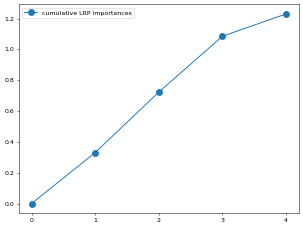

tensor([[0.7639, 0.0712, 0.1649]])
                values
info_item_9   0.723075
info_item_13  0.361935
info_item_17  0.144871


In [ ]:
# Example of local explanation in sequential implementation
m_path = f'{os.getcwd()}/lightning_logs/version_0/checkpoints/epoch=24-validation_accuracy=0.970-validation_auroc=0.963.ckpt'
importances,pred,seq = Explainer(pl_model=model,trainer=trainer,model_path=m_path).LocalExplanation(target_path=f'{os.getcwd()}/visualizations/0/449',class_code='auto',plot_sequence=True,sanity_check=True,return_sequence=True,return_pred=True)
print(torch.softmax(torch.Tensor(pred),dim=-1))
print(importances)

In [ ]:
import re
# Get model paths
trained_models = sorted([os.path.join(path,f) for path,dir,files in os.walk(f'{os.getcwd()}/lightning_logs') for f in files if f.endswith('.ckpt')])
print(trained_models)

# Get training indices
from tensorboard.backend.event_processing import event_accumulator
logs = [os.path.join(path,f) for path,dir,files in os.walk(f'{os.getcwd()}/lightning_logs') for f in files if f.startswith('events.out.tfevents')]
logs = sorted(logs)
training_indices = []
for log in sorted(logs):
  event_acc = event_accumulator.EventAccumulator(log,size_guidance={event_accumulator.SCALARS: 0})
  event_acc.Reload()
  train_pd = pd.DataFrame(event_acc.Tensors('train_idx/text_summary'))['tensor_proto']
  training_string = str(train_pd[0])
  training_string = training_string[training_string.find('[')+1:training_string.rfind(']')]
  training_string = re.sub(r'[\n\\]',' ',training_string)
  training_idx = [int(i) for i in training_string.split() if re.findall(r'\b\d+\b', i)]
  training_indices.append(training_idx)
print(len(training_indices))

['/content/lightning_logs/version_0/checkpoints/epoch=24-validation_accuracy=0.970-validation_auroc=0.963.ckpt']
1


In [ ]:
# Sequential importances (global)
import shutil
# Get global importances for sequential implementation
dest = f'{os.getcwd()}/explainer_dependencies/346'
if os.path.isdir(dest) is False:
  os.mkdir(dest)
target_path = f'{os.getcwd()}/visualizations/2/346' # User that exhibited all 20 behaviors in sequence
samples = sorted(os.listdir(target_path))
for i in range(1,21):
  shutil.copy(target_path+'/'+str(i)+'.png',dest+'/'+str(i)+'.png')

importances = []
if len(trained_models)>1:
  for trained_model in trained_models: # For each train-test split and respectively trained model
    global_importances = Explainer(pl_model=model,trainer=trainer,model_path=trained_model).GlobalExplanation(target_path=dest,softmax_importances=True) # Get global explanation
    global_importances['associated_class']=global_importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
    dfs = []
    for code in range(len(global_importances.columns)-1): # Pretty-sort according to class-based importance
      df = global_importances[global_importances['associated_class'] == code].sort_values(by=f'importances_{code}', ascending=False, inplace=False).copy()
      dfs.append(df)
    global_importances = pd.concat(dfs)
    importances.append(global_importances)
  # Get mean global importance
  merged_df = pd.concat(importances,axis=1).reindex(importances[0].index,axis=0)
  mean_importances = pd.DataFrame(index=merged_df.index,columns=list(set(merged_df.columns)))
  for col in set(merged_df.columns): # For each class, take mean of behavior importances across models
    group = merged_df.filter(regex=col)
    merged_col = group.mean(axis=1)
    mean_importances[col] = merged_col
  mean_importances = mean_importances.reindex(sorted(df.columns),axis=1).drop(['associated_class'],axis=1)
  mean_importances = mean_importances.transform(softmax,axis=0) # Softmax importances so scores reflect cross-class magnitudes
  mean_importances = mean_importances.transform(softmax,axis=1) # Softmax importances so scores reflect cross-class magnitudes
  mean_importances['associated_class']=mean_importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
else:
  mean_importances = Explainer(pl_model=model,trainer=trainer,model_path=trained_models[0]).GlobalExplanation(target_path=dest,softmax_importances=True) # Get global explanation
  mean_importances['associated_class']=mean_importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
dfs = []
for code in range(len(mean_importances.columns)-1): # Pretty-sort according to class-based importance
  df = mean_importances[mean_importances['associated_class'] == code].sort_values(by=f'importances_{code}', ascending=False, inplace=False).copy()
  dfs.append(df)
seq_importances = pd.concat(dfs)
print(seq_importances)
shutil.rmtree(f'{os.getcwd()}/explainer_dependencies/346', ignore_errors=True)

              importances_0  importances_1  importances_2  associated_class
info_item_9        0.334368       0.333091       0.332542                 0
info_item_13       0.334176       0.333029       0.332795                 0
info_item_16       0.334167       0.333173       0.332660                 0
info_item_17       0.334093       0.333103       0.332805                 0
info_item_5        0.333785       0.333102       0.333114                 0
info_item_14       0.333609       0.333397       0.332993                 0
info_item_1        0.333527       0.333247       0.333226                 0
info_item_10       0.333179       0.333621       0.333200                 1
info_item_18       0.332973       0.333571       0.333457                 1
info_item_2        0.333259       0.333530       0.333210                 1
info_item_6        0.333345       0.333454       0.333201                 1
info_item_20       0.333250       0.333442       0.333307                 1
info_item_19

In [ ]:
# Pickle sequential importances
with open(f'{os.getcwd()}/sequential_importances.pkl','wb') as dest:
  pickle.dump(seq_importances,dest,protocol=pickle.HIGHEST_PROTOCOL)

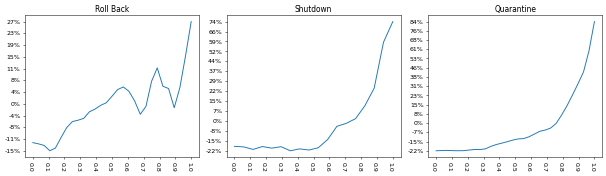

In [ ]:
# Estimate the importance of each timestep (for each class)
from scipy.interpolate import interp1d
imgs_path = os.getcwd()+'/visualizations'
classes = sorted([target.name for target in os.scandir(imgs_path) if target.is_dir]) # Get classes to predict
samples = sorted([instance.path for target in classes for instance in os.scandir(str(imgs_path)+'/'+target) if os.path.isdir(str(imgs_path)+'/'+target)]) # Get directories of user sequences
container = [[],[],[]]
for trained_model in trained_models:
  for sample in samples:
    # Get local importances for sequential implementation
    importances,pred,seq = Explainer(pl_model=model,trainer=trainer,model_path=trained_model).LocalExplanation(target_path=sample,class_code='auto',plot_sequence=False,sanity_check=False,return_sequence=True,return_pred=True)
    parent_dir = sample[:sample.rfind('/')]
    # If classification is correct
    if int(torch.argmax(torch.Tensor(pred),dim=1)) == int(parent_dir[parent_dir.rfind('/')+1:]):
      gradcams = Explainer(pl_model=model,trainer=trainer,model_path=trained_model).GradCAM(target_path=sample,hires=True,layer=4,class_code='auto',return_pred=False,show=False) # Run through HiResGradCAM function
      global_importances = [float(torch.sum(gradcam)) for gradcam in gradcams] # Get global importances from sums of each of the GradCAMs values
      softmaxed_global = softmax(global_importances) # Softmax both global and local importances
      softmaxed_local = softmax(seq)
      diffs = [(i-j)/j for i,j in zip(softmaxed_local,softmaxed_global)] # Get percentage diff between local and global
      container[int(torch.argmax(torch.Tensor(pred),dim=1))].append(diffs)
interp_container = [[],[],[]]
for ind,class_container in enumerate(container): # For each class
  maximal_len = max([len(a) for a in class_container]) # Find the longest correctly classified sequence
  for diffs in class_container: # Interpolate all sequences to match longest sequence
    interp_obj = interp1d(np.linspace(0, 1, len(diffs)), diffs)
    interp_max_len = interp_obj(np.linspace(0, 1, maximal_len))
    interp_container[ind].append(interp_max_len)
avg_diff_container = []
for ind,class_container in enumerate(interp_container): # For each class
  avg_diff = [0]*len(class_container[0]) # init average difference container
  for diff_list in class_container: # Get average difference in each timestep across inputs
    for i in range(len(diff_list)):
        avg_diff[i] += diff_list[i]
  avg_diff = [j/len(class_container) for j in avg_diff]
  avg_diff_container.append(avg_diff)
# Pickle container
with open(f'{os.getcwd()}/global-local_diffs.pkl','wb') as dest:
  pickle.dump(avg_diff_container,dest,protocol=pickle.HIGHEST_PROTOCOL)
fig = plt.figure(figsize=(6.0*len(avg_diff_container),4.0),constrained_layout=True) # Init a plot
labels = ['Roll Back','Shutdown','Quarantine']
spaces = [12,14,15]
for idx,avgs_container in enumerate(avg_diff_container):
  fig.add_subplot(1,len(avg_diff_container)+1,idx+1) # Add a subplot
  time = list(range(len(avgs_container)))
  time = [t for t in time]
  plt.plot(time,avgs_container,marker=None)
  plt.yticks(np.linspace(min(avgs_container), max(avgs_container),spaces[idx]))
  plt.xticks(np.linspace(min(time), max(time), 11))
  plt.gca().set_xticklabels([round(j/(max(plt.gca().get_xticks())),2) for j in plt.gca().get_xticks()])
  plt.gca().set_yticklabels([f'{int(round(j*100))}%' for j in plt.gca().get_yticks()])
  plt.setp(plt.gca().get_xticklabels(), rotation=-90, horizontalalignment='right')
  plt.title(labels[idx])
fig.tight_layout()
plt.show() # Show plots
plt.clf() # Close plt
plt.cla()
plt.close()

Delete the sequential model, and train a stationary model (run same local/global analyses)

In [ ]:
# Delete model and sequential visualizations
os.system(rm -rf f'{os.getcwd()}/lightning_logs')
os.system(rm -rf f'{os.getcwd()}/visualizations')

In [ ]:
# Stationary prediction
from google.colab import output
output.enable_custom_widget_manager()

# Load supplementary dataset containing metafeatures (as embeddings) of behaviors
featureframe = pd.read_csv('https://github.com/EldadTalShir/XDBA/blob/main/data/featureframe.csv',skipinitialspace=True)
featureframe['Dimension']=featureframe['Dimension'].astype(int)
featureframe['Alternative']=featureframe['Alternative'].astype(int)
featureframe.set_index('items',inplace=True)
# Load main dataset containing behavior sequences of each individual and associated class labels
df = pd.read_csv('https://github.com/EldadTalShir/XDBA/blob/main/data/dataset.csv',skipinitialspace=True)
df.set_index('pid',drop=True,inplace=True)

# Train model
seed_everything(42,workers=True) # Set seed for reproducibility
torch.use_deterministic_algorithms(True) # Use determinstic torch
data = ImageDataModule(seed=123,batch_size=4,cv_method="ho",dataframe=df,featureframe=featureframe,
                        outlier_features=['num_viewed','time'],behavior_process_column_name='info_acquisitions',delimiter=', ',label_column_name='alt_chosen',
                        affinity='cosine',linkage='single') # Initialize datasets
model = Model(num_target_classes=len(list(filter(lambda i:i>=5,df['alt_chosen'].value_counts().values))),
              conv_weights='IMAGENET1K_V1',loss_weights=torch.FloatTensor([0.0417, 0.0238, 0.0094]),
              learning_rate=float(1e-04),wd=float(1e-07),patience=2) # Initialize model
trainer = Trainer(accelerator="gpu",deterministic=True,move_metrics_to_cpu=True,num_sanity_val_steps=0,
                  max_epochs=11,log_every_n_steps=4,callbacks=[Freezer(unfreeze_at_epoch=[3]),
                  LogDataLoader(),ModelCheckpoint(filename='{epoch}-{validation_accuracy:.3f}-{validation_auroc:.3f}',monitor='epoch',mode='max',save_top_k=1,every_n_epochs=1)]) # Initialize reproducible trainer
trainer.fit(model, data) # Fit model

INFO:lightning_lite.utilities.seed:Global seed set to 42
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

INFO:lightning_lite.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_lite.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_lite.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:lightning_lite.utilities.rank_zero:HPU available: False, using: 0 HPUs


Data cleaning: dropping N/A
Encoding values for classification
Mapping: {1: 0, 2: 1, 3: 2, 4: 3}
Using micro mode to drop outlier values
Ensuring each class can be stratified into 5 strata
Using FAMD for dimensionality reduction
Using silhouette score to choose number of clusters
Agg. clustering items by cosine affinity and single linkage for 6 clusters


Using the heldout method


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | conv      | ResNet           | 42.5 M
-----------------------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params
170.025   Total estimated model params size (MB)
INFO:lightning_lite.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/conne

Training: 0it [00:00, ?it/s]

Epoch 0: Freezing all layers other than model head
Training 0.0M params out of 42.5M


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 3: Unfreezing layers
Training 42.5M params out of 42.5M


Validation: 0it [00:00, ?it/s]

Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning_lite.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=11` reached.


<Figure size 271x180.667 with 0 Axes>

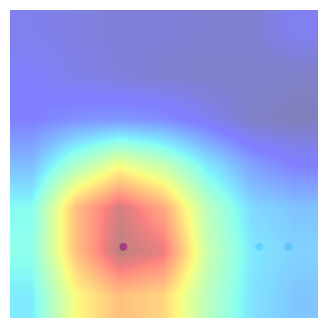

Sanity check ok?: True
tensor([ 2.4400, -2.6248, -0.7518])
tensor([0.9547, 0.0060, 0.0392])
                values
info_item_9   1.809121
info_item_13  0.476487
info_item_17  0.154429


In [ ]:
# Example of GradCAM and local explanation in stationary implementation
m_path = f'{os.getcwd()}/lightning_logs/version_0/checkpoints/epoch=10-validation_accuracy=0.909-validation_auroc=0.895.ckpt'
class_code = 'auto'
maps = Explainer(pl_model=model,trainer=trainer,model_path=m_path).GradCAM(hires=True,target_path=f'{os.getcwd()}/visualizations/0/449.png',class_code=class_code,interpolation='bilinear')
importances,pred=Explainer(pl_model=model,trainer=trainer,model_path=m_path).LocalExplanation(target_path=f'{os.getcwd()}/visualizations/0/449.png',class_code=class_code,sanity_check=True,return_pred=True)
print(pred)
print(torch.softmax(torch.Tensor(pred),dim=-1))
print(importances)

In [ ]:
import re
# Get model paths
trained_models = sorted([os.path.join(path,f) for path,dir,files in os.walk(f'{os.getcwd()}/lightning_logs') for f in files if f.endswith('.ckpt')])
print(trained_models)

# Get training indices
from tensorboard.backend.event_processing import event_accumulator
logs = [os.path.join(path,f) for path,dir,files in os.walk(f'{os.getcwd()}/lightning_logs') for f in files if f.startswith('events.out.tfevents')]
logs = sorted(logs)
training_indices = []
for log in sorted(logs):
  event_acc = event_accumulator.EventAccumulator(log,size_guidance={event_accumulator.SCALARS: 0})
  event_acc.Reload()
  train_pd = pd.DataFrame(event_acc.Tensors('train_idx/text_summary'))['tensor_proto']
  training_string = str(train_pd[0])
  training_string = training_string[training_string.find('[')+1:training_string.rfind(']')]
  training_string = re.sub(r'[\n\\]',' ',training_string)
  training_idx = [int(i) for i in training_string.split() if re.findall(r'\b\d+\b', i)]
  training_indices.append(training_idx)
print(len(training_indices))

['/content/lightning_logs/version_0/checkpoints/epoch=10-validation_accuracy=0.909-validation_auroc=0.895.ckpt']
1


In [ ]:
# Global explanation of stationary implementation
class_importances = []
if len(trained_models)>1:
  for ind,training_idx in enumerate(training_indices): # For each train-test split and respectively trained model
    global_importances = Explainer(pl_model=model,trainer=trainer,model_path=trained_models[0]).GlobalExplanation(absolute_importances=False,softmax_importances=True,n_repeats=5) # Get global explanation
    importances = global_importances.copy()
    importances['associated_class']=importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
    dfs = []
    for code in range(len(global_importances.columns.values)): # Pretty-sort according to class-based importance
      df = importances[importances['associated_class'] == code].sort_values(by=f'importances_{code}', ascending=False, inplace=False).copy()
      dfs.append(df)
    concatenated_importances = pd.concat(dfs)
    class_importances.append(concatenated_importances)
  # Get mean global importance
  merged_df = pd.concat(class_importances,axis=1).reindex(class_importances[0].index,axis=0)
  mean_importances = pd.DataFrame(index=merged_df.index,columns=list(set(merged_df.columns)))
  for col in set(merged_df.columns): # For each class, take mean of behavior importances across models
    group = merged_df.filter(regex=col)
    merged_col = group.mean(axis=1)
    mean_importances[col] = merged_col
  mean_importances = mean_importances.reindex(sorted(df.columns),axis=1).drop(['associated_class'],axis=1)
  mean_importances = mean_importances.transform(softmax,axis=0) # Softmax importances so scores reflect cross-class magnitudes  
  mean_importances = mean_importances.transform(softmax,axis=1) # Softmax importances so scores reflect cross-class magnitudes
  mean_importances['associated_class']=mean_importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
else:
  importances = Explainer(pl_model=model,trainer=trainer,model_path=trained_models[0]).GlobalExplanation(absolute_importances=False,softmax_importances=True,n_repeats=30) # Get global explanation
  mean_importances = importances.copy()
  mean_importances['associated_class']=mean_importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
dfs = []
for code in range(len(mean_importances.columns)-1): # Pretty-sort according to class-based importance
  df = mean_importances[mean_importances['associated_class'] == code].sort_values(by=f'importances_{code}', ascending=False, inplace=False).copy()
  dfs.append(df)
stationary_importances = pd.concat(dfs)
print(stationary_importances)

              importances_0  importances_1  importances_2  associated_class
info_item_13       0.335006       0.332099       0.332895                 0
info_item_5        0.334623       0.332684       0.332693                 0
info_item_17       0.334082       0.332781       0.333137                 0
info_item_9        0.333857       0.332796       0.333348                 0
info_item_11       0.333593       0.333005       0.333402                 0
info_item_6        0.333429       0.334916       0.331655                 1
info_item_10       0.332784       0.334218       0.332998                 1
info_item_15       0.332668       0.333918       0.333414                 1
info_item_2        0.332784       0.333837       0.333379                 1
info_item_1        0.332622       0.333751       0.333627                 1
info_item_7        0.333246       0.333622       0.333132                 1
info_item_16       0.332856       0.333290       0.333854                 2
info_item_19

In [ ]:
# Pickle stationary importances
with open(f'{os.getcwd()}/stationary_importances.pkl','wb') as dest:
  pickle.dump(stationary_importances,dest,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Get mean global importance across stationary and sequential implementations
with open(f'{os.getcwd()}/sequential_importances.pkl','rb') as dest:
  seq_importances = pickle.load(dest)
with open(f'{os.getcwd()}/stationary_importances.pkl','rb') as dest:
  stationary_importances = pickle.load(dest)
stationary_importances = stationary_importances.sort_index()
seq_importances = seq_importances.sort_index()
stationary_importances.drop('associated_class',axis=1,inplace=True)
seq_importances.drop('associated_class',axis=1,inplace=True)
merged_df = pd.concat([seq_importances,stationary_importances],axis=1)
mean_importances = pd.DataFrame(index=merged_df.index,columns=list(set(merged_df.columns)))
for col in set(merged_df.columns): # For each class, take mean of behavior importances across models
  group = merged_df.filter(regex=col)
  merged_col = group.mean(axis=1)
  mean_importances[col] = merged_col
mean_importances = mean_importances.reindex(sorted(stationary_importances.columns),axis=1) # Reorder columns
mean_importances = mean_importances.transform(softmax,axis=0) # Softmax importances so scores reflect cross-class magnitudes
mean_importances = mean_importances.transform(softmax,axis=1) # Softmax importances so scores reflect cross-class magnitudes
mean_importances['associated_class']=mean_importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
dfs = []
for code in range(len(mean_importances.columns)-1): # Pretty-sort according to class-based importance
  df = mean_importances[mean_importances['associated_class'] == code].sort_values(by=f'importances_{code}', ascending=False, inplace=False).copy()
  dfs.append(df)
final_importances = pd.concat(dfs)
print(final_importances)

              importances_0  importances_1  importances_2  associated_class
info_item_13       0.333354       0.333321       0.333325                 0
info_item_5        0.333348       0.333326       0.333326                 0
info_item_9        0.333346       0.333327       0.333327                 0
info_item_17       0.333346       0.333327       0.333327                 0
info_item_16       0.333336       0.333332       0.333332                 0
info_item_14       0.333335       0.333333       0.333332                 0
info_item_6        0.333334       0.333348       0.333318                 1
info_item_10       0.333327       0.333343       0.333329                 1
info_item_2        0.333328       0.333339       0.333333                 1
info_item_7        0.333331       0.333336       0.333333                 1
info_item_1        0.333329       0.333336       0.333335                 1
info_item_19       0.333321       0.333331       0.333348                 2
info_item_8 

Check if surrogate model obtains the same class-based importances as the original model (ResNet101)

In [ ]:
# Train a decision-tree classifier as a surrogate model
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import accuracy_score
imgs_path = os.getcwd()+'/visualizations'
behavior_counts = os.getcwd()+'/explainer_dependencies/behavior_counts.pkl'
with open(behavior_counts,'rb') as dest: # Load behavior counts, saved during preprocessing
  behavior_counts = pickle.load(dest)
behavior_counts['class_pred'] = 0
samples = sorted([[os.path.join(path,f),os.path.join(path,f)[os.path.join(path,f).rfind('/')+1:os.path.join(path,f).rfind('.png')]] for path,dir,files in os.walk(imgs_path) for f in files if f.endswith('.png')]) # Get list of behavior visualizations
model_path=trained_models[0] # Get trained model path
model = model.load_from_checkpoint(checkpoint_path=model_path)
model = model.eval()
for idx,data in enumerate(samples):
  img = Image.open(data[0]).convert('RGB') # Open input image
  transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Same transforms as in training/validation
  tensor_image = transform(img).float() # Apply transforms
  predimg = tensor_image.unsqueeze(0) # Unsqueeze for forwarding to classifier without batch
  pred = model(predimg)
  behavior_counts.loc[int(data[1]),'class_pred']=int(torch.argmax(pred)) # Append predicted class label
train_df = behavior_counts.iloc[training_indices[0],:] # Init train-valid datasets
valid_indices = [i for i in range(len(samples)) if i not in training_indices[0]]
valid_df = behavior_counts.iloc[valid_indices,:]
X_train = train_df.drop('class_pred',axis=1) # Init training X,y dfs, X's are normalized behavior counts
y_train = train_df['class_pred'] # Y's are class preds
X_valid = valid_df.drop('class_pred',axis=1)
y_valid = valid_df['class_pred']
out = pd.DataFrame(columns=['criterion','m_depth','m_features','auroc','accuracy'])
for crit in ['gini','entropy','log_loss']:
  for m_depth in [None,2,3,4,5,6,7,8,9,10,12,15,20]:
    for m_feat in ['sqrt','log2',None]:
      proxy_model = DTC(criterion=crit,max_depth=m_depth,max_features=m_feat,random_state=42).fit(X_train,y_train)
      y_pred=proxy_model.predict_proba(X_valid) # Predict on validation dataset
      bin_ys = label_binarize(y_valid,classes=[0,1,2])
      arc = roc_auc_score(y_true=bin_ys,y_score=y_pred,multi_class='ovr',average='micro') # Calculate AUROC
      y_pred=proxy_model.predict(X_valid) # Predict on validation dataset
      acc = accuracy_score(y_true=y_valid,y_pred=y_pred) # Calculate accuracy
      out = pd.concat([out,pd.Series({'criterion':crit,'m_depth':m_depth,'m_features':m_feat,'auroc':arc,'accuracy':acc}).to_frame().T],ignore_index=True)
out = out.where(pd.notnull(out), None)
best = out[out.accuracy==out.accuracy.max()] # Get best accuracy
best = best.sort_values(by=['auroc','accuracy'],ascending=False) # Within best accuracy, get best AUROC
arc=float(best['auroc'].tolist()[0])
acc=float(best['accuracy'].tolist()[0])
print(f"AUROC of classic proxy model (w.r.t. original model predictions): {arc}")
print(f"accuracy of classic proxy model (w.r.t. original model predictions): {acc}")

AUROC of classic proxy model (w.r.t. original model predictions): 0.837962962962963
accuracy of classic proxy model (w.r.t. original model predictions): 0.7777777777777778


In [ ]:
# Use best surrogate model to get feature importances
crit=best['criterion'].tolist()[0]
m_depth=best['m_depth'].tolist()[0]
m_feat=best['m_features'].tolist()[0]
proxy_model = DTC(criterion=crit,max_depth=m_depth,max_features=m_feat,random_state=42).fit(X_train,y_train)
workdir=str(os.getcwd())
target_path = workdir+'/visualizations'
behavior_counts = workdir+'/explainer_dependencies/behavior_counts.pkl'
with open(behavior_counts,'rb') as dest: # Load behavior counts, saved during preprocessing
  behavior_counts = pickle.load(dest)
data_coords = workdir+'/explainer_dependencies/data_coordinates.pkl'
with open(data_coords,'rb') as dest: # Load behavior coordinates, saved during preprocessing
  item_coordinates = pickle.load(dest)
samples = {os.path.join(path,f)[os.path.join(path,f).rfind('/')+1:os.path.join(path,f).rfind('.png')]:os.path.join(path,f) for path,dir,files in os.walk(target_path) for f in files if f.endswith('.png')} # Get dict of behavior visualizations
samples = dict(sorted(samples.items(), key=lambda item:item[1]))
classes = sorted([int(target.name) for target in os.scandir(target_path) if target.is_dir]) # Get classes to predict
importances = pd.DataFrame(0,index=list(item_coordinates.index),columns=[f'importances_{i}' for i in classes],dtype=float)
scores=pd.DataFrame(0,columns=['original_pred'],index=list(samples.keys()),dtype=int) # Create a dataframe to hold original and permuted logits
y_pred=proxy_model.predict(behavior_counts) # Predict on permuted dataset
scores[f'original_pred']=y_pred # Append logits to entry in scores df
n_repeats=30
for behavior_to_permute in list(item_coordinates.index): # For each unique behavior
  random_state = np.random.RandomState(42)
  X_permuted = behavior_counts.copy() # Copy to ensure that original df isn't permuted
  shuffling_idx = np.arange(X_permuted.shape[0]) # Get indices of entries
  col_idx = X_permuted.columns.get_loc(behavior_to_permute) # Get behavior's column loc
  permuted_preds = pd.DataFrame(0, columns=[f'permuted_pred_{i}' for i in range(n_repeats)], index=list(samples.keys()),dtype=int) # Create a dataframe to hold permuted logits
  for repeat in range(n_repeats):
    no_zeros_only = False
    while not no_zeros_only: # Permute behavior, but check that no individual has zero behaviors due to permutation
      random_state.shuffle(shuffling_idx)
      col = X_permuted.iloc[shuffling_idx, col_idx]
      col.index = X_permuted.index
      X_permuted[X_permuted.columns[col_idx]] = col
      no_zeros_only = ~(X_permuted == 0.0).all(axis=1).any()
    y_pred=proxy_model.predict(X_permuted) # Predict on permuted dataset
    permuted_preds[f'permuted_pred_{repeat}']=y_pred # Append logits to entry in scores df
  cat_scores = scores.copy()
  cat_scores['model_pred'] = scores['original_pred']
  cat_scores['true_label'] = [int(samples[key][:samples[key].rfind('/')][samples[key][:samples[key].rfind('/')].rfind('/')+1:]) for key in list(cat_scores.index)]
  model_accs = {}
  permuted_accs = {}
  for c in classes:
    model_accs[c]=0
    permuted_accs[c]=0
  for value in cat_scores['true_label'].unique(): # Get class-based accuracies for true data
    sub_df = cat_scores.loc[cat_scores['true_label']==value]
    value_counts = pd.Series(sub_df['true_label']==sub_df['model_pred']).sum()
    model_accs[value]=value_counts/len(sub_df)
  for r in range(n_repeats): # Get class-based accuracies for permuted data
    permuted_df = permuted_preds.copy()
    permuted_df['permuted_pred'] = permuted_preds[f'permuted_pred_{r}']
    permuted_df = permuted_df.reindex(index=cat_scores.index)
    permuted_df['true_label'] = cat_scores['true_label']
    for value in permuted_df['true_label'].unique():
      sub_df = permuted_df.loc[permuted_df['true_label']==value]
      value_counts = pd.Series(sub_df['true_label']==sub_df['permuted_pred']).sum()
      permuted_accs[value]+=value_counts/(len(sub_df)*n_repeats)
  for c in classes:
    importances.at[behavior_to_permute,f'importances_{c}']=model_accs[c]-permuted_accs[c] # Set r_true-avg(r_permuted) as importance where r is class accuracy
softmax_importances=True
if softmax_importances is True: # Softmax importances so scores reflect cross-class magnitudes
  importances = importances.transform(softmax,axis=0)
  importances = importances.transform(softmax,axis=1)
importances['associated_class']=importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
dfs = []
for code in range(len(importances.columns)-1): # Pretty-sort according to class-based importance
  df = importances[importances['associated_class'] == code].sort_values(by=f'importances_{code}', ascending=False, inplace=False).copy()
  dfs.append(df)
assigned_importances = pd.concat(dfs)
print(assigned_importances)

              importances_0  importances_1  importances_2  associated_class
info_item_13       0.337505       0.331596       0.330899                 0
info_item_5        0.336464       0.331462       0.332074                 0
info_item_10       0.334137       0.333749       0.332114                 0
info_item_19       0.333731       0.332657       0.333611                 0
info_item_6        0.330917       0.336149       0.332933                 1
info_item_15       0.332406       0.334009       0.333585                 1
info_item_11       0.332662       0.333832       0.333505                 1
info_item_1        0.332955       0.333340       0.333705                 2
info_item_2        0.332955       0.333340       0.333705                 2
info_item_4        0.332955       0.333340       0.333705                 2
info_item_7        0.332955       0.333340       0.333705                 2
info_item_8        0.332955       0.333340       0.333705                 2
info_item_9 

In [ ]:
# Check how many behaviors are in agreement between surrogate and actual model
with open(f'{os.getcwd()}/stationary_importances.pkl','rb') as dest:
  stationary_importances = pickle.load(dest)
stationary_importances = stationary_importances.sort_index()
assigned_importances = assigned_importances.sort_index()
merged_df = assigned_importances.merge(stationary_importances,left_on=assigned_importances.index,right_on=stationary_importances.index)
mask = merged_df['associated_class_x'] == merged_df['associated_class_y']
filtered_df = merged_df[mask].copy()
filtered_df.drop(['associated_class_x','associated_class_y'],axis=1,inplace=True)
filtered_df.rename(columns={'key_0':'behaviors'},inplace=True)
filtered_df.set_index('behaviors',inplace=True)
mean_importances = pd.DataFrame(index=filtered_df.index,columns=[f'importances_{i}' for i in range(len(stationary_importances.columns)-1)])
for col in mean_importances.columns: # For each class, take mean of behavior importances across models
  group = filtered_df.filter(regex=col)
  merged_col = group.mean(axis=1)
  mean_importances[col] = merged_col
mean_importances['associated_class']=mean_importances.apply(lambda x: x.argmax(), axis=1) # Assign an associated class by max behavior score
dfs=[]
for code in range(len(mean_importances.columns)-1): # Pretty-sort according to class-based importance
  df = mean_importances[mean_importances['associated_class'] == code].sort_values(by=f'importances_{code}', ascending=False, inplace=False).copy()
  dfs.append(df)
final_importances = pd.concat(dfs)
print(final_importances)
acc = accuracy_score(y_true=stationary_importances['associated_class'],y_pred=np.asarray(assigned_importances['associated_class'])) # Calculate accuracy
bacc = balanced_accuracy_score(y_true=stationary_importances['associated_class'],y_pred=np.asarray(assigned_importances['associated_class'])) # Calculate accuracy
print(f'Surrogate classifier global-importance assignment error: {1-acc}\nSurrogate classifier global-importance assign. balanced error: {1-bacc}')

              importances_0  importances_1  importances_2  associated_class
behaviors                                                                  
info_item_13       0.336255       0.331847       0.331897                 0
info_item_5        0.335543       0.332073       0.332384                 0
info_item_6        0.332173       0.335533       0.332294                 1
info_item_15       0.332537       0.333964       0.333499                 1
info_item_16       0.332905       0.333315       0.333779                 2
info_item_20       0.333004       0.333261       0.333735                 2
info_item_18       0.333012       0.333291       0.333698                 2
info_item_4        0.332986       0.333324       0.333690                 2
info_item_8        0.332959       0.333369       0.333673                 2
info_item_12       0.333054       0.333311       0.333635                 2
info_item_14       0.333077       0.333293       0.333630                 2
info_item_3 

Benchmark tests (holdout test for random forests, logistic regression, ridge regression)

In [ ]:
# Check if random forests is any better
from sklearn.ensemble import RandomForestClassifier
import scipy
classes = set(sorted([int(target.name) for target in os.scandir(str(f'{os.getcwd()}/visualizations')) if target.is_dir]))
with open(str(f'{os.getcwd()}/explainer_dependencies/behavior_counts.pkl'),'rb') as dest: # Load agent behavior counts, saved during preprocessing (typify_agents function)
  bcounts = pickle.load(dest)
labels = {int(os.path.join(path,f)[os.path.join(path,f).rfind('/')+1:os.path.join(path,f).rfind('.png')]):int(os.path.join(path)[os.path.join(path).rfind('/')+1:]) for path,dir,files in os.walk(str(f'{os.getcwd()}/visualizations')) for f in files if f.endswith('.png')} # Get dict of behavior visualizations
bcounts['label']=0
for ind in bcounts.index:
  bcounts.loc[ind,'label']=labels[ind]

# Grid search for each trained model
aurocs = []
accuracies = []
for training_idx in training_indices:
  train_df = bcounts.iloc[training_idx,:] # Init train-valid datasets
  valid_idx = [i for i in range(len(bcounts)) if i not in training_idx]
  valid_df = bcounts.iloc[valid_idx,:]
  X_train = train_df.drop('label',axis=1,inplace=False)
  y_train = train_df['label']
  X_valid = valid_df.drop('label',axis=1,inplace=False)
  y_valid = valid_df['label']
  out = pd.DataFrame(columns=['n_est','criterion','m_depth','m_features','auroc','accuracy'])
  for n_est in [50,75,100,150,200]:
    for crit in ['gini','entropy','log_loss']:
      for m_depth in [None,2,3,4,5,6,7,8,9,10,12,15,20]:
        for m_feat in ['sqrt','log2',None]:
          randf = RandomForestClassifier(n_estimators=n_est,criterion=crit,max_depth=m_depth,max_features=m_feat,class_weight={0:0.0417, 1:0.0238, 2:0.0094},random_state=42).fit(X_train,y_train)
          y_pred=randf.predict_proba(X_valid) # Predict on validation dataset
          bin_ys = label_binarize(y_valid,classes=sorted(classes))
          arc = roc_auc_score(y_true=bin_ys,y_score=y_pred,multi_class='ovr',average='micro') # Calculate AUROC
          y_pred=randf.predict(X_valid) # Predict on validation dataset
          acc = balanced_accuracy_score(y_true=y_valid,y_pred=y_pred) # Calculate accuracy
          out = pd.concat([out,pd.Series({'n_est':n_est,'criterion':crit,'m_depth':m_depth,'m_features':m_feat,'auroc':arc,'accuracy':acc}).to_frame().T],ignore_index=True)
  # Print best tuned classifier's performance metrics
  out = out.where(pd.notnull(out), None)
  best = out[out.accuracy==out.accuracy.max()] # Get best accuracy
  best = best.sort_values(by=['auroc','accuracy'],ascending=False) # Within best accuracy, get best AUROC
  arc=float(best['auroc'].tolist()[0])
  acc=float(best['accuracy'].tolist()[0])
  print(acc,arc)
  aurocs.append(arc)
  accuracies.append(acc)
if len(aurocs)>1:
  print(f"Tuned random-forests mean balanced accuracy: {np.mean(accuracies)}; 95% CI: {np.mean(accuracies)-abs(scipy.stats.t.ppf(0.025,len(accuracies)-1))*np.std(accuracies,ddof=1)/np.sqrt(len(accuracies))}-{np.mean(accuracies)+abs(scipy.stats.t.ppf(0.025,len(accuracies)-1))*np.std(accuracies,ddof=1)/np.sqrt(len(accuracies))}")
  print(f"Tuned random-forests mean AUROC: {np.mean(aurocs)}; 95% CI: {np.mean(aurocs)-abs(scipy.stats.t.ppf(0.025,len(aurocs)-1))*np.std(aurocs,ddof=1)/np.sqrt(len(aurocs))}-{np.mean(aurocs)+abs(scipy.stats.t.ppf(0.025,len(aurocs)-1))*np.std(aurocs,ddof=1)/np.sqrt(len(aurocs))}")

0.8282828282828283 0.8888888888888888


In [ ]:
# Check if logistic regression is any better
from sklearn.linear_model import LogisticRegression
import scipy
classes = set(sorted([int(target.name) for target in os.scandir(str(f'{os.getcwd()}/visualizations')) if target.is_dir]))
with open(str(f'{os.getcwd()}/explainer_dependencies/behavior_counts.pkl'),'rb') as dest: # Load agent behavior counts, saved during preprocessing (typify_agents function)
  bcounts = pickle.load(dest)
labels = {int(os.path.join(path,f)[os.path.join(path,f).rfind('/')+1:os.path.join(path,f).rfind('.png')]):int(os.path.join(path)[os.path.join(path).rfind('/')+1:]) for path,dir,files in os.walk(str(f'{os.getcwd()}/visualizations')) for f in files if f.endswith('.png')} # Get dict of behavior visualizations
bcounts['label']=0
for ind in bcounts.index:
  bcounts.loc[ind,'label']=labels[ind]
aurocs = []
accuracies = []
for training_idx in training_indices:
  train_df = bcounts.iloc[training_idx,:] # Init train-valid datasets
  valid_idx = [i for i in range(len(bcounts)) if i not in training_idx]
  valid_df = bcounts.iloc[valid_idx,:]
  X_train = train_df.drop('label',axis=1,inplace=False)
  y_train = train_df['label']
  X_valid = valid_df.drop('label',axis=1,inplace=False)
  y_valid = valid_df['label']
  logreg = LogisticRegression(multi_class='multinomial',class_weight='balanced',random_state=42).fit(X_train,y_train)
  y_pred=logreg.decision_function(X_valid) # Predict probabilities on validation dataset
  y_pred = np.exp(y_pred)/np.sum(np.exp(y_pred), axis=1, keepdims=True) # Softmax
  bin_ys = label_binarize(y_valid,classes=sorted(classes))
  arc = roc_auc_score(y_true=bin_ys,y_score=y_pred,multi_class='ovr',average='micro') # Calculate AUROC
  y_pred=logreg.predict(X_valid) # Predict classes on validation dataset
  acc = balanced_accuracy_score(y_true=y_valid,y_pred=y_pred) # Calculate accuracy
  print(acc,arc)
  aurocs.append(arc)
  accuracies.append(acc)
if len(aurocs)>1:
  print(f"Logistic regression mean balanced accuracy: {np.mean(accuracies)}; 95% CI: {np.mean(accuracies)-abs(scipy.stats.t.ppf(0.025,len(accuracies)-1))*np.std(accuracies,ddof=1)/np.sqrt(len(accuracies))}-{np.mean(accuracies)+abs(scipy.stats.t.ppf(0.025,len(accuracies)-1))*np.std(accuracies,ddof=1)/np.sqrt(len(accuracies))}")
  print(f"Logistic regression mean AUROC: {np.mean(aurocs)}; 95% CI: {np.mean(aurocs)-abs(scipy.stats.t.ppf(0.025,len(aurocs)-1))*np.std(aurocs,ddof=1)/np.sqrt(len(aurocs))}-{np.mean(aurocs)+abs(scipy.stats.t.ppf(0.025,len(aurocs)-1))*np.std(aurocs,ddof=1)/np.sqrt(len(aurocs))}")

0.712121212121212 0.763888888888889


In [ ]:
# Check if ridge regression is any better
from sklearn.linear_model import RidgeClassifier
import scipy
classes = set(sorted([int(target.name) for target in os.scandir(str(f'{os.getcwd()}/visualizations')) if target.is_dir]))
with open(str(f'{os.getcwd()}/explainer_dependencies/behavior_counts.pkl'),'rb') as dest: # Load agent behavior counts, saved during preprocessing (typify_agents function)
  bcounts = pickle.load(dest)
labels = {int(os.path.join(path,f)[os.path.join(path,f).rfind('/')+1:os.path.join(path,f).rfind('.png')]):int(os.path.join(path)[os.path.join(path).rfind('/')+1:]) for path,dir,files in os.walk(str(f'{os.getcwd()}/visualizations')) for f in files if f.endswith('.png')} # Get dict of behavior visualizations
bcounts['label']=0
for ind in bcounts.index:
  bcounts.loc[ind,'label']=labels[ind]
aurocs = []
accuracies = []
for training_idx in training_indices:
  train_df = bcounts.iloc[training_idx,:] # Init train-valid datasets
  valid_idx = [i for i in range(len(bcounts)) if i not in training_idx]
  valid_df = bcounts.iloc[valid_idx,:]
  X_train = train_df.drop('label',axis=1,inplace=False)
  y_train = train_df['label']
  X_valid = valid_df.drop('label',axis=1,inplace=False)
  y_valid = valid_df['label']
  ridge = RidgeClassifier(class_weight='balanced',fit_intercept=True,random_state=42).fit(X_train,y_train)
  y_pred=ridge.decision_function(X_valid) # Predict probabilities on validation dataset
  y_pred = np.exp(y_pred)/np.sum(np.exp(y_pred), axis=1, keepdims=True) # Softmax
  bin_ys = label_binarize(y_valid,classes=sorted(classes))
  arc = roc_auc_score(y_true=bin_ys,y_score=y_pred,multi_class='ovr',average='micro') # Calculate AUROC
  y_pred=ridge.predict(X_valid) # Predict classes on validation dataset
  acc = balanced_accuracy_score(y_true=y_valid,y_pred=y_pred) # Calculate accuracy
  print(acc,arc)
  aurocs.append(arc)
  accuracies.append(acc)
if len(aurocs)>1:
  print(f"Ridge regression mean balanced accuracy: {np.mean(accuracies)}; 95% CI: {np.mean(accuracies)-abs(scipy.stats.t.ppf(0.025,len(accuracies)-1))*np.std(accuracies,ddof=1)/np.sqrt(len(accuracies))}-{np.mean(accuracies)+abs(scipy.stats.t.ppf(0.025,len(accuracies)-1))*np.std(accuracies,ddof=1)/np.sqrt(len(accuracies))}")
  print(f"Ridge regression mean AUROC: {np.mean(aurocs)}; 95% CI: {np.mean(aurocs)-abs(scipy.stats.t.ppf(0.025,len(aurocs)-1))*np.std(aurocs,ddof=1)/np.sqrt(len(aurocs))}-{np.mean(aurocs)+abs(scipy.stats.t.ppf(0.025,len(aurocs)-1))*np.std(aurocs,ddof=1)/np.sqrt(len(aurocs))}")

0.712121212121212 0.7561728395061728
